# Project 4 : West Nile Virus Prediction

## Problem Statement

To create a model to predict the presence of West Nile Virus(WNV) based on geospatial and weather information and identify the most important influencing features in Chicago, Illinois.

## Evaluation of model

Models are evaluated by Classification accuracy, precision, recall and f1 score.

Accuracy is the total percent of predictions a model gets right.

$$\text{Accuracy}={\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}}$$
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

$$\text{Precision}={\frac{True Positive}{True Positive + False Positive}}$$
Recall is the ratio of correctly predicted positive observations to the all observations in positive class.

$$\text{Recall = Sensitivity}={\frac{True Positive}{True Positive + False Negative}}$$
F1 score is weighted average of the precision and recall. F1 score reaches its best value at 1 and worst score at 0.

$$\text{F1}={\frac{2 * Precision * Recall}{Precision + Recall}}$$

-----------------------------

For this problem, we would prefer to have higher sensitivity/recall due to the negative impact of False Negatives.

Kaggle score was based on on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.

## Target audience

This model is targeted at Chicago City health officials, as it will help them identify hotspots where carriers of the West Nile Virus may see a spike in populations, or even take preventive or preemptive actions to curb the growth of WNV carriers.

## Sections

- [Import libraries](#Import-libraries)
- [Load Data](#Load-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis and Feature Engineering](#Exploratory-Data-Analysis-and-Feature-Engineering)
- [Feature Selection and Modeling](#Feature-Selection-and-Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Approach A](#Approach-A)
    - [Approach B](#Approach-B)
    - [Approach C](#Approach-C)
    - [Approach D](#Approach-D)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [Annex A - Data Dictionary for main_df](#Annex-A---Data-Dictionary-for-main_df)

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, BaggingClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

import pyreadr
import myfunctions as f
import io
import re

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline

## Load Data

In [2]:
df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## Data Cleaning

### General Cleaning for all dataframes

In [3]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


**Comment**

df_test differs from df_train in that it does not have the `WnvPresent` column, which is expected since it is the predicted variable, but also the `NumMosquitos` column. It also has an extra `Id` column

In [5]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [6]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [7]:
# Apply lower() to column names for all 4 dataframes
df_weather.columns = df_weather.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_spray.columns = df_spray.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [8]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Test dataset')
print(df_test.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)

Train dataset
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

Test dataset
id                          int64
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
dtype: object

Weather dataset
station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoin

In [9]:
# Change Date datatype to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [10]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Test dataset')
print(df_test.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)

Train dataset
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

Test dataset
id                                 int64
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
dtype: object



In [11]:
# Create `day`, `month` and `year` columns for all 4 dataframes
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

df_weather['day'] = df_weather['date'].map(lambda x: x.day)
df_weather['month'] = df_weather['date'].map(lambda x: x.month)
df_weather['year'] = df_weather['date'].map(lambda x: x.year)

df_train['day'] = df_train['date'].map(lambda x: x.day)
df_train['month'] = df_train['date'].map(lambda x: x.month)
df_train['year'] = df_train['date'].map(lambda x: x.year)

df_test['day'] = df_test['date'].map(lambda x: x.day)
df_test['month'] = df_test['date'].map(lambda x: x.month)
df_test['year'] = df_test['date'].map(lambda x: x.year)

In [12]:
# View data shapes
print(f'Train dataset: {df_train.shape}')
print(f'Weather dataset: {df_weather.shape}')
print(f'Spray dataset: {df_spray.shape}')
print(f'Test dataset: {df_test.shape}')

Train dataset: (10506, 15)
Weather dataset: (2944, 25)
Spray dataset: (14835, 7)
Test dataset: (116293, 14)


In [13]:
# Check for NA values
print(f'Train dataset: {df_train.isnull().sum().sum()}')
print(f'Weather dataset: {df_weather.isnull().sum().sum()}')
print(f'Spray dataset: {df_spray.isnull().sum().sum()}')
print(f'Test dataset: {df_test.isnull().sum().sum()}')

Train dataset: 0
Weather dataset: 0
Spray dataset: 584
Test dataset: 0


### Data cleaning for df_spray

In [14]:
# Closer look at Spray dataset
print(df_spray.isnull().sum())

date           0
time         584
latitude       0
longitude      0
day            0
month          0
year           0
dtype: int64


**Comment**

Column 'Time' has 584 empty cells but it is not important for our analysis.
The null values does not appear at random. Therefore, we will drop the column

In [15]:
df_spray.drop(columns='time',inplace=True)

In [16]:
df_spray.head()

,date,latitude,longitude,day,month,year
0,2011-08-29,42.391623,-88.089163,29,8,2011
1,2011-08-29,42.391348,-88.089163,29,8,2011
2,2011-08-29,42.391022,-88.089157,29,8,2011
3,2011-08-29,42.390637,-88.089158,29,8,2011
4,2011-08-29,42.390410,-88.088858,29,8,2011


### Data cleaning for df_weather

In [17]:
# Define function to replace entires with M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df):
    df.replace(['M','-',' ', '  T'],
               [np.nan, np.nan, np.nan, 0.05],
               inplace = True)
    
update_cols(df_weather)

In [18]:
df_weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007


**Comment**

External research yields the following information for some of the parameters:

**Depart**

Departure from normal. The difference between column 4 and the 30 year normal temperature 
for this date. A minus (-) is number of degrees below normal.
A zero (0) indicates that the average for that day was the Normal.

**Wet bulb**

The Wet bulb temperature is the temperature the air needs to be cooled to (at constant pressure) 
in order to achieve a relative humidity (RH) of 100%.

**DewPoint**

At 100% relative humidity, the dew point temperature is equal to the air temperature 
(dry-bulb temperature) and it is lower at lower humidity.

In [19]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

water1         2944
codesum        1609
depart         1472
sunrise        1472
sunset         1472
depth          1472
snowfall       1472
tavg             11
cool             11
heat             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
preciptotal       2
tmin              0
tmax              0
date              0
year              0
dewpoint          0
month             0
resultspeed       0
resultdir         0
day               0
station           0
dtype: int64

In [20]:
# Drop water1 column as it is missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Replace Nan values in codesum column with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

In [21]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
day                     int64
month                   int64
year                    int64
dtype: object

In [22]:
# convert datatypes to float
col_toflt = ['preciptotal', 'stnpressure', 'sealevel',
             'avgspeed', 'preciptotal', 'tavg',
             'depart', 'wetbulb', 'heat', 'cool',
             'sunrise', 'sunset']

for col in col_toflt:
    df_weather[col] = df_weather[col].astype(float)

In [23]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                  object
snowfall               object
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
day                     int64
month                   int64
year                    int64
dtype: object

In [24]:
# Define function to convert temperature to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for conversion
    
    Returns:
    df
    '''
    for name in column_names:
        try:
            df[name] = round((df[name]-32)*5/9,2)
        except TypeError:
            continue
    return df

df_weather =  fahrenheit_to_celsius(df_weather,
                                    ['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

In [25]:
# Verify that conversion is successful
df_weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,28.33,10.00,19.44,-10.00,10.56,13.33,0.0,2.0,...,0.0,0.0,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,28.89,11.11,20.00,NaN,10.56,13.89,0.0,3.0,...,NaN,0.0,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,15.00,5.56,10.56,-19.44,5.56,8.33,14.0,0.0,...,0.0,0.0,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,15.56,6.11,11.11,NaN,5.56,8.33,13.0,0.0,...,NaN,0.0,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,18.89,7.78,13.33,-16.67,4.44,8.89,9.0,0.0,...,0.0,0.0,29.39,30.12,11.7,7,11.9,3,5,2007


## Exploratory Data Analysis and Feature Engineering

### EDA - Weather dataset

In [26]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]
# Resetting indices
df_weather_st1.reset_index(inplace=True,drop=True)
df_weather_st2.reset_index(inplace=True,drop=True)

In [27]:
# Checking for missing values from station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        3
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    2
sealevel       5
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [28]:
# Checking for missing values from station 2
df_weather_st2.isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

**Comment**

It is noted that station 2 has a lot more missing values compared to station 1.

In [29]:
# Merging two station in one df
weather_two_stations = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [30]:
# Creation a function for scatter plots
def scatter(column_list,df=weather_two_stations):
    '''
    Takes:
    column_list (list of str) - list of column names
    df - dataframe
    Plot scatterplot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        try:
            ax[a,c].scatter(x,y)
            ax[a,c].set_title(name,fontsize=15)
            ax[a,c].set_ylabel('Station 1')
            ax[a,c].set_xlabel('Station 2')
            plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        except:
            pass

In [31]:
# Create list of columns to plot scatter plot and remove irrelevant entries
col_forscatter = list(weather_two_stations.columns)

col_forscatter.remove('date')
col_forscatter.remove('station_x')
col_forscatter.remove('codesum_x')
col_forscatter.remove('station_y')
col_forscatter.remove('codesum_y')

In [32]:
# Choosing columns for scatterplots
column_names = [name.split('_')[0] for name in col_forscatter]
# Leave only unique names of columns
column_names = list(set(column_names))

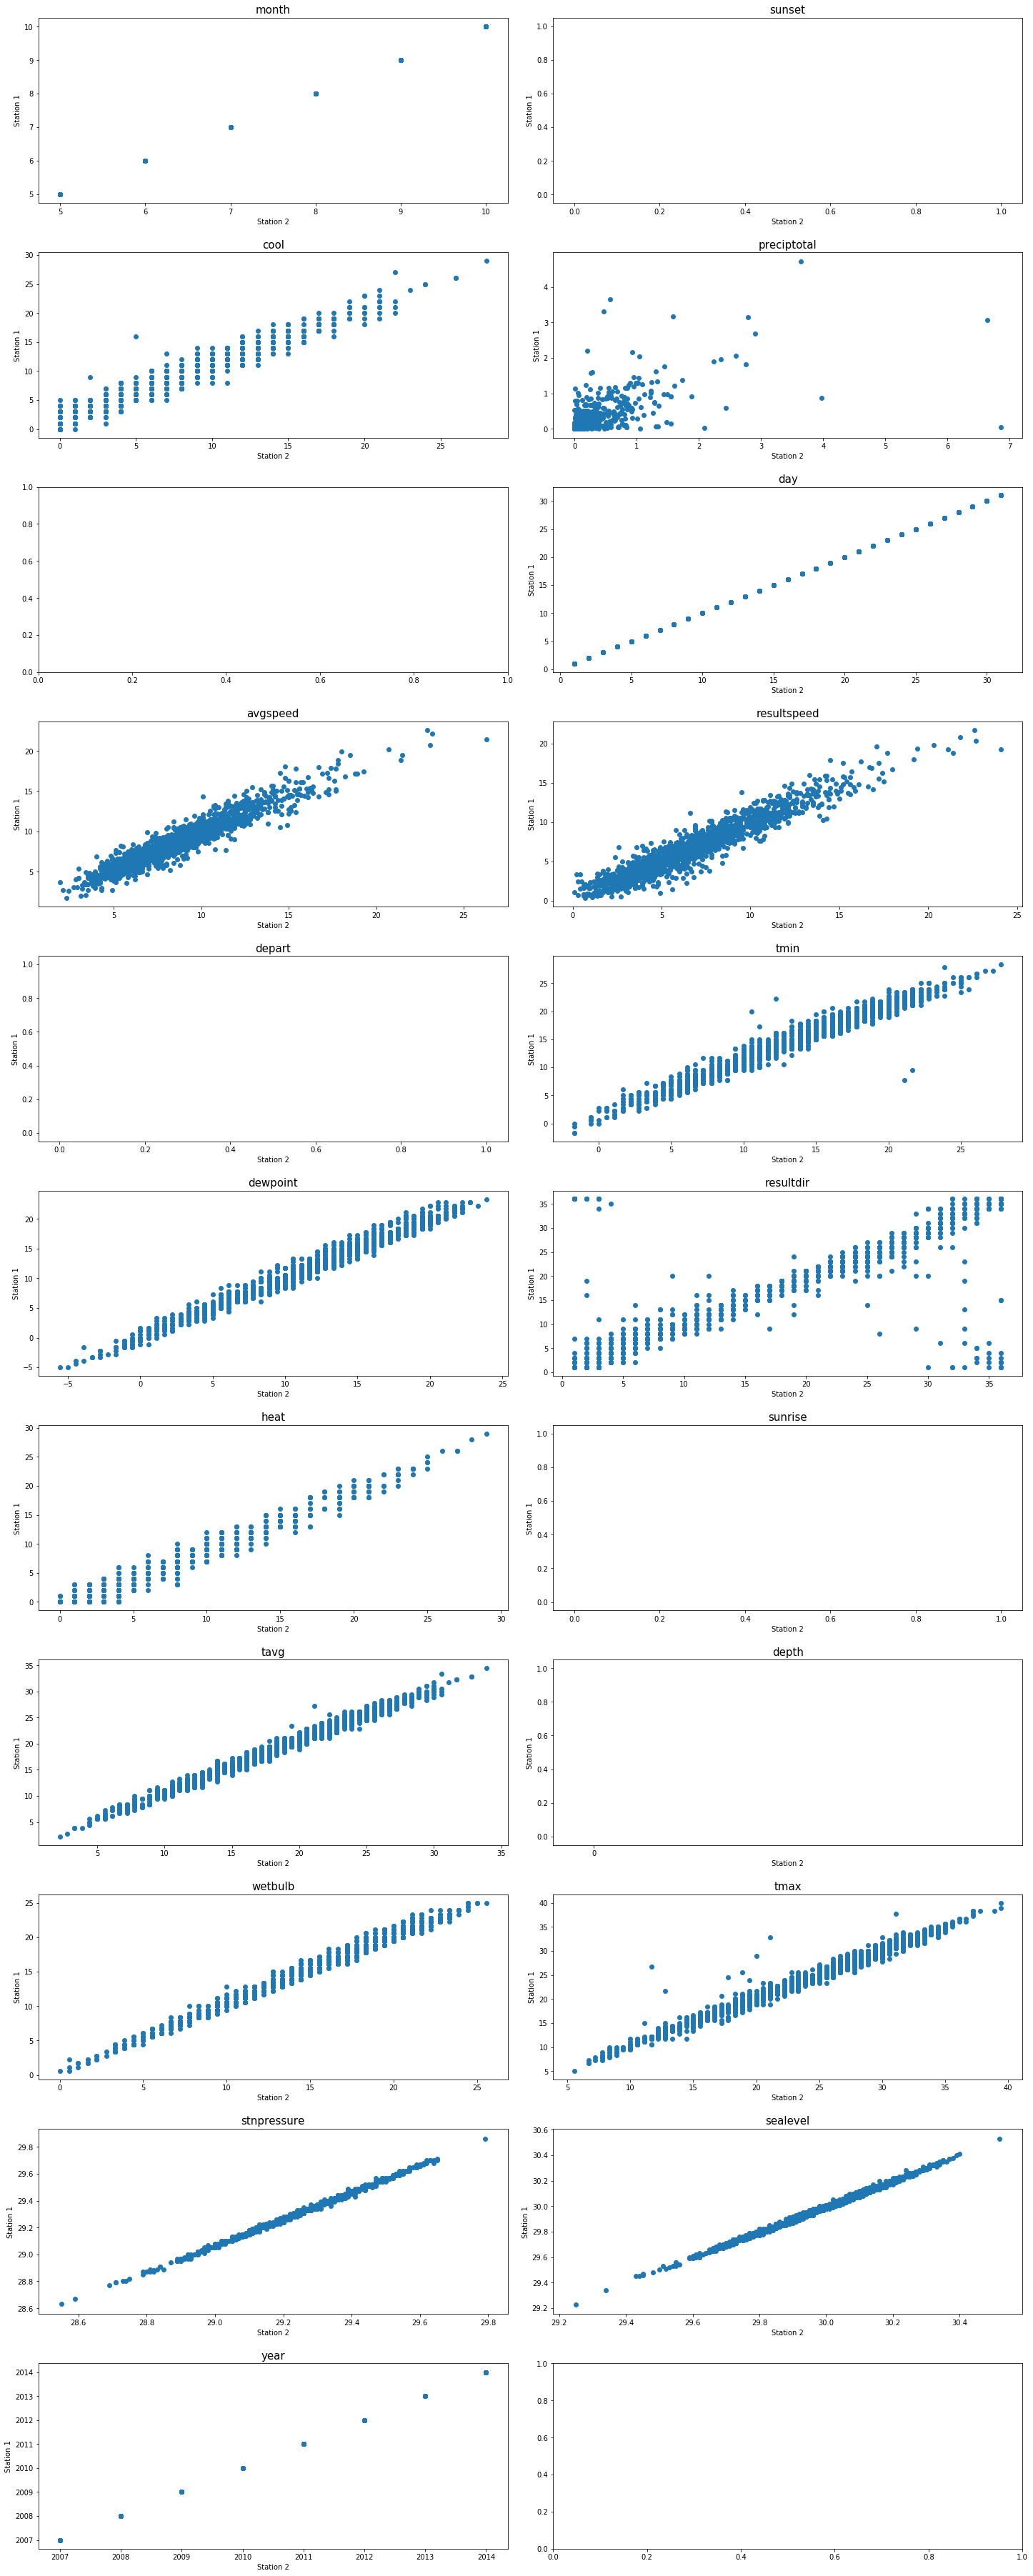

In [33]:
scatter(column_names)

**Comment**

As graphs above have shown, weather data from station 1 and station 2 are very similar.
However, station 1 has a lot less missing values. Therefore, the team's decision is to fill `nan` values in station 1 with information from station 2 and exclude station 2.

In [34]:
# Create dataframe subset of station 1 which only shows rows with `nan` values 
index_st1=df_weather_st1[df_weather_st1.isnull().any(axis=1)].index
df_weather_st1[df_weather_st1.isnull().any(axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,1,2009-06-18,26.67,16.11,21.67,-17.22,17.22,19.44,0.0,6.0,...,0.0,0.12,29.08,NaN,6.7,16,7.9,18,6,2009
424,1,2009-06-26,30.00,20.56,25.56,-13.89,15.56,NaN,0.0,13.0,...,0.0,0.00,NaN,29.85,6.4,4,8.2,26,6,2009
497,1,2009-09-07,25.00,15.00,20.00,-17.22,15.00,16.67,0.0,3.0,...,0.0,0.00,29.39,NaN,5.8,3,4.0,7,9,2009
866,1,2011-09-08,23.89,13.89,18.89,-17.78,11.67,15.00,0.0,1.0,...,0.0,0.05,29.34,NaN,13.0,2,13.4,8,9,2011
878,1,2011-09-20,23.33,9.44,16.67,-17.78,12.22,14.44,3.0,0.0,...,0.0,0.00,29.26,NaN,7.3,18,7.3,20,9,2011
1045,1,2012-09-03,31.11,21.67,26.67,-11.11,21.11,22.78,0.0,15.0,...,0.0,0.00,29.17,NaN,4.6,6,4.4,3,9,2012
1205,1,2013-08-10,27.22,17.78,22.78,-17.78,13.89,NaN,0.0,8.0,...,0.0,0.00,NaN,30.08,5.3,5,6.5,10,8,2013
1206,1,2013-08-11,27.22,15.56,21.67,-18.89,16.11,NaN,0.0,6.0,...,0.0,0.01,29.35,30.07,2.0,27,3.0,11,8,2013


In [35]:
# Find corresponding rows from station 2
df_weather_st2.loc[index_st1,:]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,2,2009-06-18,27.22,17.22,22.22,NaN,17.78,19.44,0.0,7.0,...,NaN,0.11,29.15,29.79,3.7,17,5.8,18,6,2009
424,2,2009-06-26,30.00,22.22,26.11,NaN,16.11,19.44,0.0,14.0,...,NaN,0.00,29.20,29.83,6.4,4,8.0,26,6,2009
497,2,2009-09-07,25.00,17.22,21.11,NaN,15.00,17.22,0.0,5.0,...,NaN,0.00,29.44,30.09,6.3,4,6.9,7,9,2009
866,2,2011-09-08,23.33,16.67,20.00,NaN,12.22,15.00,0.0,3.0,...,NaN,0.06,29.36,30.03,14.9,2,15.2,8,9,2011
878,2,2011-09-20,23.89,11.67,17.78,NaN,12.22,14.44,1.0,0.0,...,NaN,0.01,29.33,29.99,5.8,17,6.1,20,9,2011
1045,2,2012-09-03,30.56,22.78,26.67,NaN,20.56,22.78,0.0,15.0,...,NaN,0.00,29.23,29.87,5.0,7,5.9,3,9,2012
1205,2,2013-08-10,27.22,20.00,23.89,NaN,12.78,17.22,0.0,10.0,...,NaN,0.00,NaN,30.07,6.0,6,7.4,10,8,2013
1206,2,2013-08-11,28.89,17.22,23.33,NaN,13.89,17.78,0.0,9.0,...,NaN,0.05,29.42,30.06,4.0,24,5.4,11,8,2013


In [36]:
# Filling NA in station 1 with info from station 2
df_weather_st1.loc[:,'wetbulb'].fillna(df_weather_st2['wetbulb'],inplace=True)
df_weather_st1.loc[:,'stnpressure'].fillna(df_weather_st2['stnpressure'],inplace=True)
df_weather_st1.loc[:,'sealevel'].fillna(df_weather_st2['sealevel'],inplace=True)

# NOTE: row with index 1205 has missing values in both stations. 
# It will be filled with information from the next day
df_weather_st1.loc[:,'stnpressure'].fillna(29.42,inplace=True);

C:\Users\junyu\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [37]:
# Check for any more null values in station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

**Comment**

External research showed that mosquitoe breeding activity is closely related to weather conditions from 2 weeks prior.
This might be related to their breeding cycles. Hence, we will be creating a new feature which indicates the weather condition from 2 weeks prior and also a humidity column based on the difference between the dry air temperature and the dew point temperature.

In [38]:
# Function to add feature which indicates humidity
def add_humidity(df):
    df['humidity'] = df['tavg'] - df['dewpoint']

In [39]:
add_humidity(df_weather_st1)

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
df_weather_st1

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,humidity
0,1,2007-05-01,28.33,10.00,19.44,-10.00,10.56,13.33,0.0,2.0,...,0.00,29.10,29.82,1.7,27,9.2,1,5,2007,8.88
1,1,2007-05-02,15.00,5.56,10.56,-19.44,5.56,8.33,14.0,0.0,...,0.00,29.38,30.09,13.0,4,13.4,2,5,2007,5.00
2,1,2007-05-03,18.89,7.78,13.33,-16.67,4.44,8.89,9.0,0.0,...,0.00,29.39,30.12,11.7,7,11.9,3,5,2007,8.89
3,1,2007-05-04,18.89,9.44,14.44,-15.56,5.00,10.00,7.0,0.0,...,0.05,29.31,30.05,10.4,8,10.8,4,5,2007,9.44
4,1,2007-05-05,18.89,11.67,15.56,-15.00,3.33,9.44,5.0,0.0,...,0.05,29.40,30.10,11.7,7,12.0,5,5,2007,12.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1,2014-10-27,25.00,10.56,17.78,-8.89,10.56,14.44,1.0,0.0,...,0.00,28.92,29.66,12.0,19,12.9,27,10,2014,7.22
1468,1,2014-10-28,20.00,7.22,13.89,-12.22,3.33,8.33,8.0,0.0,...,0.05,29.15,29.85,14.8,26,15.6,28,10,2014,10.56
1469,1,2014-10-29,9.44,2.22,6.11,-20.00,0.00,4.44,22.0,0.0,...,0.00,29.36,30.06,9.5,29,9.9,29,10,2014,6.11
1470,1,2014-10-30,10.56,0.00,5.56,-20.00,1.11,4.44,23.0,0.0,...,0.00,29.34,30.09,5.1,24,5.5,30,10,2014,4.45


### EDA - Spray dataset

**Comment**

We will be creating clusters to seperate the jobs done on each day when spraying was performed.

In [41]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [42]:
# Standardizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for prediction
dbs = DBSCAN(eps=0.4)
dbs.fit(X_scaled)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [43]:
# Verifying labels (there should be 13)
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [44]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [45]:
df_spray.head()

,date,latitude,longitude,day,month,year,labels
0,2011-08-29,42.391623,-88.089163,29,8,2011,0
1,2011-08-29,42.391348,-88.089163,29,8,2011,0
2,2011-08-29,42.391022,-88.089157,29,8,2011,0
3,2011-08-29,42.390637,-88.089158,29,8,2011,0
4,2011-08-29,42.390410,-88.088858,29,8,2011,0


In [46]:
# Plot out spray jobs to visually see clustering.

# Due to the time-consuming nature of the plotting, set 'on' to True to plot
# if cell output has been cleared.
on= False

if on:
    for uniqdate in list(df_spray['date'].unique()):
        df =  df_spray[df_spray['date']==uniqdate]
        f.gen_map()
        plt.scatter(x=df['longitude'],y=df['latitude'],c=df['labels'],cmap='Spectral')

**Comment**

Based on the plots above, there are some spray jobs which falls outside the area of Chicago.
Therefore, we will remove the irrelevant entries.

In [47]:
# Remove rows which falls outside area of interest
df_spray = df_spray.loc[df_spray['longitude'] > -88]

#### Generate rectangular spray-affected regions based on the minimum and maximum latitude and longitude values for each spray job

In [48]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [49]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max'] 

In [50]:
min_max_spray

,date,latitude_min,longitude_min,latitude_max,longitude_max
labels,,,,,
1,2011-09-07,41.968435,-87.836560,41.997028,-87.787710
2,2013-07-17,41.997728,-87.788258,42.015098,-87.762165
3,2013-07-17,41.972617,-87.871023,41.973142,-87.870150
4,2013-07-17,41.714098,-87.672362,41.743287,-87.629355
5,2013-07-25,41.939308,-87.739840,41.968097,-87.707987
6,2013-08-08,41.917227,-87.716847,41.946703,-87.678060
7,2013-08-15,41.887825,-87.818408,41.966532,-87.745625
8,2013-08-22,41.873487,-87.730655,41.895475,-87.701623
9,2013-08-22,41.713925,-87.623142,41.765277,-87.586727


### EDA - Train dataset

In [51]:
df_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


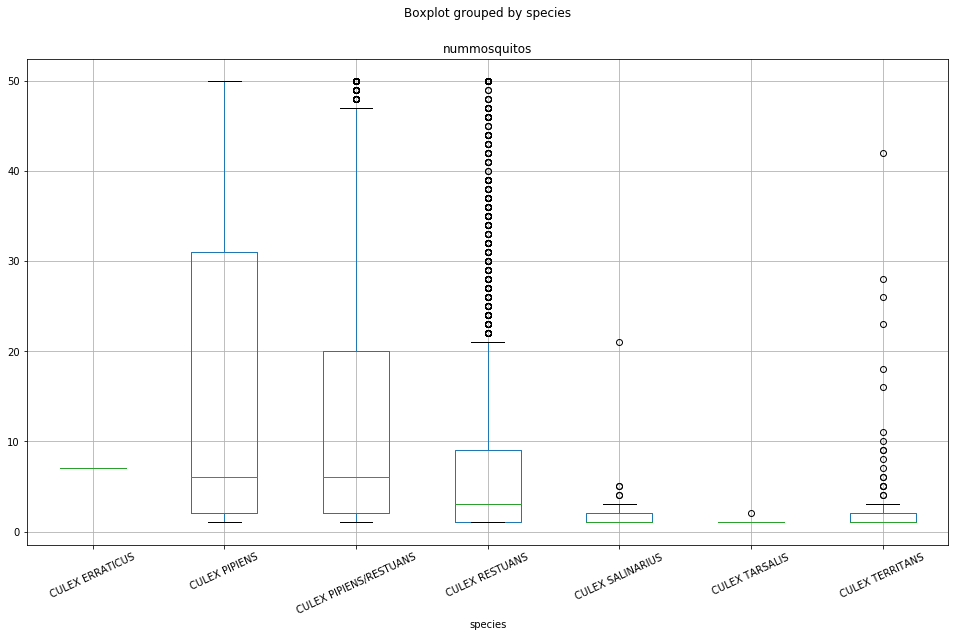

In [52]:
# Plot species of mosquitos against number of mosquitoes
df_train.boxplot(by='species',column='nummosquitos',rot=25, figsize=(16,9));

In [53]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

**Comment**

3 species of mosquitos caught much more frequently than the others - Culex Pipiens, Culex Restuans and Culex Pipiens/Restuans

Records exist only when a particular species of mosquitos is found at a certain trap at a certain time. 

Date: date that the WNV test is performed

In [54]:
# Tabulate NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


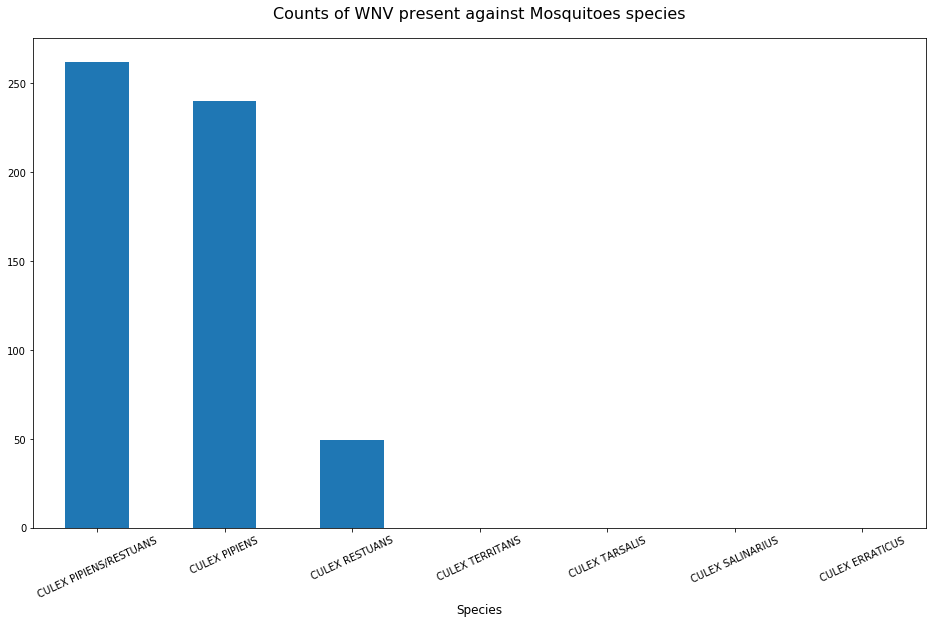

In [55]:
# Plot Mosquitoe species against counts of WNV presence
df_train.groupby('species')['wnvpresent'].sum().sort_values(ascending=False).plot.bar(figsize=(16,9),rot=25);
plt.title("Counts of WNV present against Mosquitoes species",size=16, pad=20);
plt.xlabel('Species', size =12);

**Comment**

Based on the above, only mosquitoes which are of the species Culex Pipiens, Culex Pipiens/Restuans and Culex Restuans will carry the West Nile Virus. Therefore, a new boolean feature which indicates whether the mosquitoes caught in each trap are of these few species is created.

In [56]:
# Creating new column which indicates whether mosquitoes caught in the trap have the virus
df_train['iswnvspecies'] = df_train['species'].str.contains('PIPIENS|RESTUANS').astype(int)
df_test['iswnvspecies'] = df_test['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [57]:
# Get top 10 traps with highest occurance of West Nile Virus
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,wnvpresent,nummosquitos
trap,,
T143,0.193548,7.419355
T006,0.166667,4.458333
T005,0.142857,3.571429
T233,0.140000,15.160000
T014,0.133333,12.133333
T096,0.120000,11.560000
T003,0.114754,11.032787
T015,0.114286,4.828571
T235,0.112903,8.983871


#### Merge df_train by date, followed by by trap to get total number of moquitoes per trap per day to evaluate the impact of spraying on mosquito populations

In [58]:
def chkWNV(series):
    return 1 if series.sum() > 0 else 0

In [59]:
# Merge by Date, followed by Trap
def mergebydate_time():
    df_merged = pd.DataFrame(columns=['date', 'address', 'species',
                                      'block', 'street', 'trap',
                                      'addressnumberandstreet',
                                      'latitude', 'longitude',
                                      'addressaccuracy',
                                      'nummosquitos', 'wnvpresent'])

    for date_trap, df in df_train_groupbydate_trap:
        df_merged.loc[len(df_merged)] = [date_trap[0],
                                         np.unique(df['address'])[0],
                                         np.unique(df['species']),
                                         np.unique(df['block'])[0],
                                         np.unique(df['street'])[0],
                                         date_trap[1], 
                                         np.unique(df['addressnumberandstreet'])[0], 
                                         np.unique(df['latitude'])[0],
                                         np.unique(df['longitude'])[0],
                                         np.unique(df['addressaccuracy'])[0],
                                         sum(df['nummosquitos']),
                                         chkWNV(df['wnvpresent'])]
    return df_merged

In [60]:
def add_ispraycol(df):
    df['is_spray'] = False

    tdelta_min = dt.timedelta(days=0)
    tdelta_max = dt.timedelta(days=30)

    # Looping through df with min,max latitudes and longitudes
    for i,spray in min_max_spray.iterrows():
        long_min = spray['longitude_min']
        long_max = spray['longitude_max']
        lat_min = spray['latitude_min']
        lat_max = spray['latitude_max']

    # Looping through train df, checking is latitudes and longitudes lay between min and max
    # and date is the same date or date +30 days of spraying 
        for j,row in df.iterrows():
            if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
                if ((lat_min <= row['latitude'] <= lat_max) &
                    (long_min <= row['longitude'] <= long_max)):
                    df.loc[j,'is_spray'] = True

In [61]:
on= False

if on:
    # Group by date, followed by by trap
    df_train_groupbydate_trap = df_train.groupby(['date','trap'])
    
    # merge data from the same traps in the same day into one row
    df_train_bydate_trap = mergebydate_time()
    
    # Change `date` to datetime dtype
    df_train_bydate_trap['date'] = pd.to_datetime(df_train_bydate_trap['date'])
    
    # Break up `species` from list format to one continuous string
    df_train_bydate_trap['species'] = df_train_bydate_trap['species'].apply(','.join)
    
    # Create `iswnvspecies` column
    df_train_bydate_trap['iswnvspecies'] = df_train_bydate_trap['species'].str.contains('PIPIENS|RESTUANS').astype(int)
    
    # Create `is_spray` column
    add_ispraycol(df_train_bydate_trap)
    
    # Save to csv to save time
    df_train_bydate_trap.to_csv('../datasets/df_train_bydate_trap.csv', index=False)

In [62]:
# Load csv
df_train_bydate_trap = pd.read_csv('../datasets/df_train_bydate_trap.csv')

# Change `date` to datetime dtype
df_train_bydate_trap['date'] = pd.to_datetime(df_train_bydate_trap['date'])

In [63]:
# Get list of traps which were inside the spray region during spray dates
spray_trap = df_train_bydate_trap[df_train_bydate_trap['is_spray']==1].loc[:,['trap']]['trap'].unique()

# Remove 6th entry as it has insufficient entries and therefore is unable to 
spray_trap = np.delete(spray_trap,5)

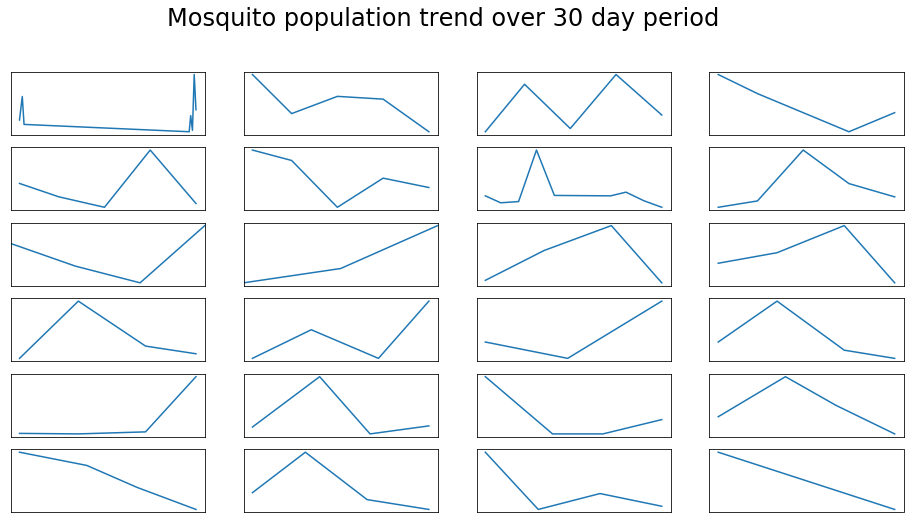

In [64]:
# Plot mosquito population trend over 30 day period after spraying is conducted
fig, ax = plt.subplots(nrows=6,ncols=4, figsize=(16,9))
ax = ax.ravel()

for i, trap in enumerate(spray_trap):
    df = df_train_bydate_trap[df_train_bydate_trap['trap']==trap]
    df[df['is_spray']==1].plot(x='date',y='nummosquitos',ax=ax[i],);
    ax[i].get_legend().remove()
    ax[i].set_xticks([],minor=True)
    ax[i].set_xticks([],minor=False)
    ax[i].set_yticks([])
    ax[i].set_xlabel('')

fig.suptitle('Mosquito population trend over 30 day period', size=24);

**Comment**

Though some of the plots indicate a decline in mosquito population after spraying is conducted, there are also a number of plots where there is not definitive decline. Thererfore, it is not conclusive whether spraying has a definitive impact on the mosquito population.

#### Temporarily merge df_train and df_weather for EDA

In [65]:
# Create temporary dataframe by merging cleaned df_train and df_weather dataframes
df = pd.merge(df_train, df_weather_st1, on="date")

# Select a few columns for analysis
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

# Create another temporary variable, this is the mean temperature, mosquitos and wnv present
df_mean = df.groupby(['date']).mean()

# Segregate species that carry WNV or not
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]

# Segregate Non-Pipiens / Restuans (0), Pip&Rest w/o WNV (1), Pip&Rest with WNV (0)
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

# Create 2 temporary dataframes to categorise data by month (average for weather, total for mosquito and virus data)
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']

df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


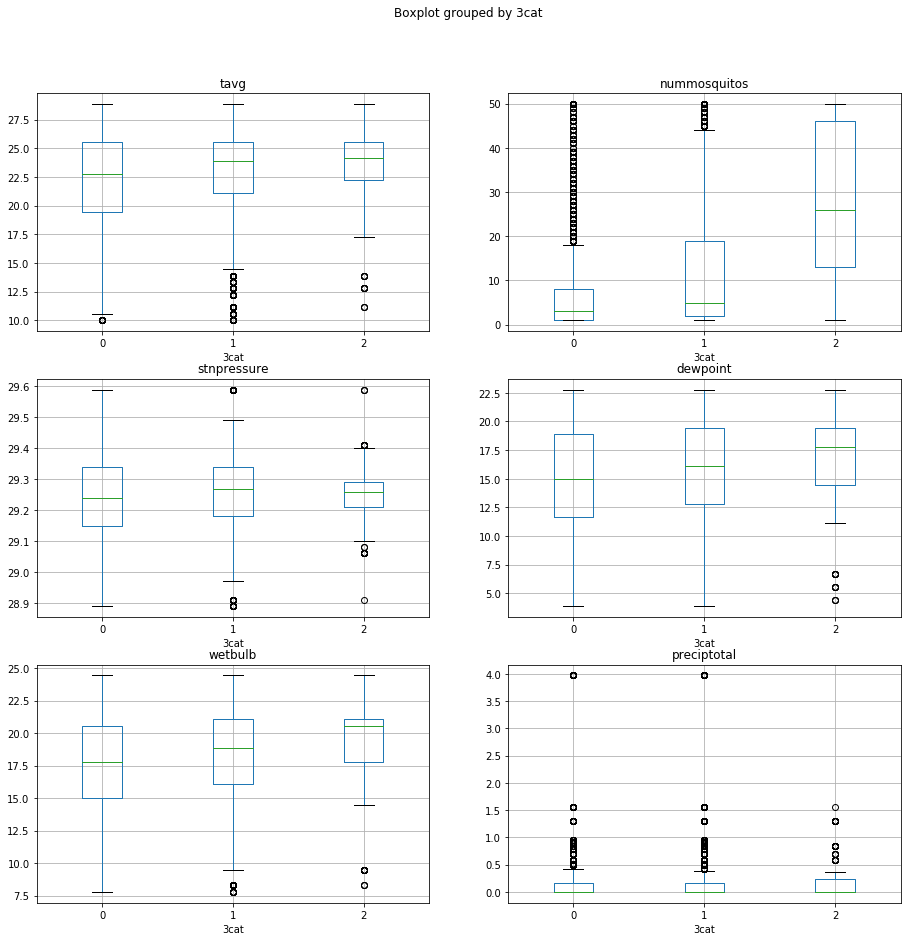

In [66]:
# Category labels:
# 0 [Non-Pipiens & Restuans (Statistically 0 WNV Present)]
# 1 [Pipiens & Restuans with NO WNV]
# 2 [Pipiens & Restuans WITH WNV]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

plt.show()

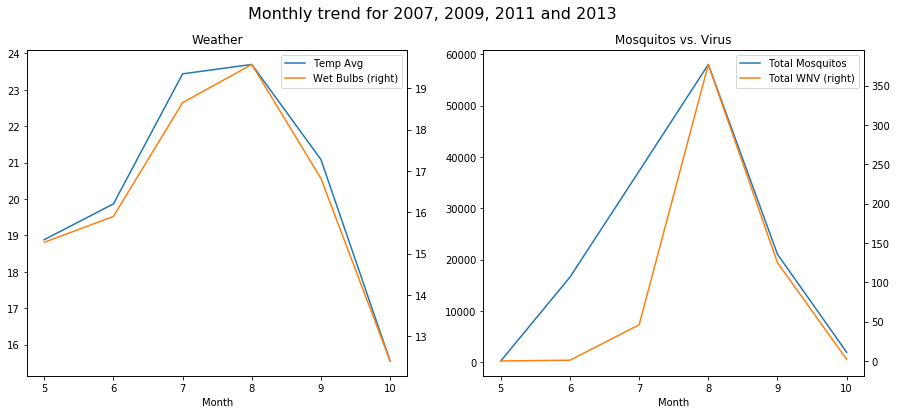

In [67]:
# Month by month analysis for training dataset

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')
axes[0].set_xlabel('Month')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Mosquitos vs. Virus')
axes[1].set_xlabel('Month')

plt.show()

In [68]:
# Merge final weather set df_weather_st1, with df_train for specific columns that would be needed to perform EDA 
weather_eda1 = pd.merge(df_weather_st1, df_train[['date','species','wnvpresent','nummosquitos']], on='date')
numeric_df = weather_eda1._get_numeric_data()

C:\Users\junyu\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


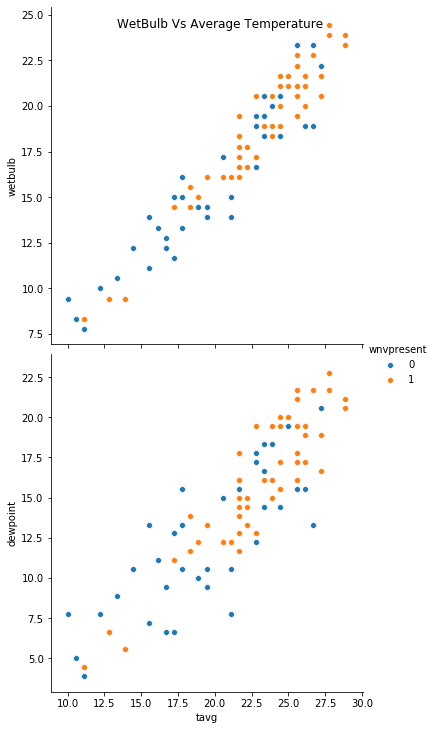

In [69]:
# Looking at the correlation between  Westbulb, Dewpoint and Avg Temp
sns.pairplot(data=weather_eda1, x_vars='tavg', y_vars=['wetbulb', 'dewpoint'],
             hue='wnvpresent', size=5).fig.suptitle("WetBulb Vs Average Temperature",);

- Looking further into the relationship between WnvPresent, Average Temperature, Dewpoint and Wetbulb.
- We could see the positive correlation, as the graph above shows when Average Temperature is above 20 degrees there's an increase in number of WnvPresent while for Wetbulb it is 16 deg celsius.
- For Dewpoint the graph shows when its above 12 degrees, there will be an increase in WnvPresent.

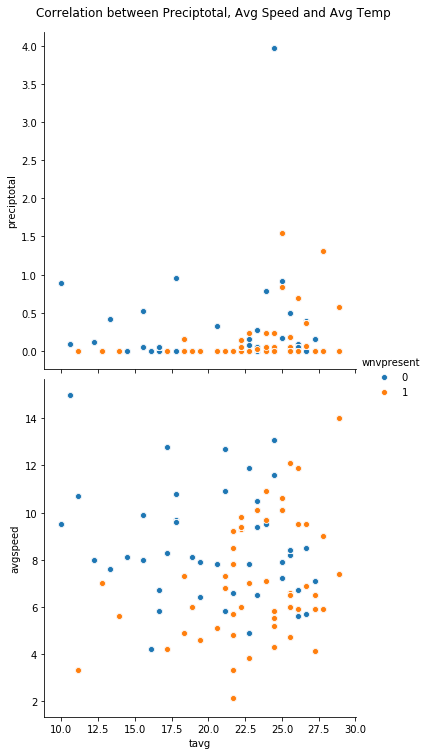

In [70]:
sns.pairplot(data=weather_eda1, x_vars='tavg', y_vars=['preciptotal', 'avgspeed'],
             hue='wnvpresent', size=5).fig.suptitle("Correlation between Preciptotal, Avg Speed and Avg Temp",y=1.03);

- Looking at the precipitation graph, shows there's very little to no correlation between Average Temperature and WnvPresent. The number of WnvPresent is increasing only due to rise in Average Temperature while Precipitation remains near 0.

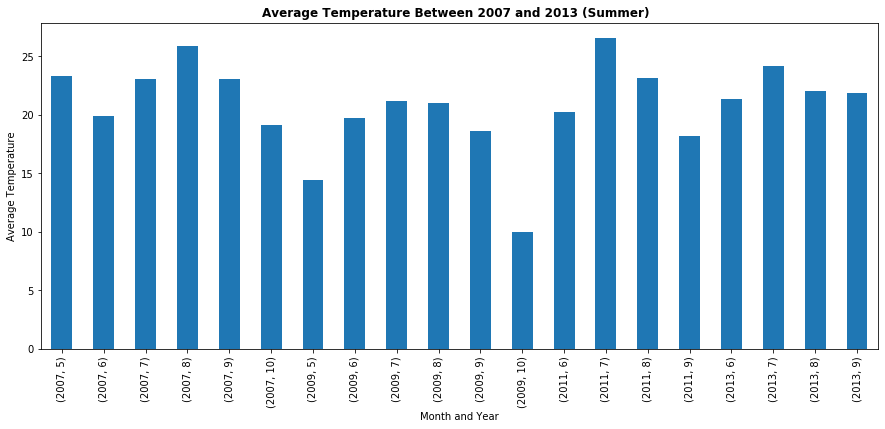

In [71]:
# Overview of average temperature across the summer months of 2007 to 2013
weather_eda1.groupby(['year','month']).tavg.mean().plot(kind='bar', figsize=(15,6))
plt.title('Average Temperature Between 2007 and 2013 (Summer)  ', weight= 'bold')
plt.grid(False)
plt.xlabel('Month and Year')
plt.ylabel('Average Temperature')
plt.show()

- Year over year, we notice from the bar chart above July and August are the hottest months during summer.
- In 2009, there was drop in average temperature during the summer months (May-October) compared to 2007.
- This was due to above then normal rainfalls, presistent cloudiness and cooling winds from Lake Michigan

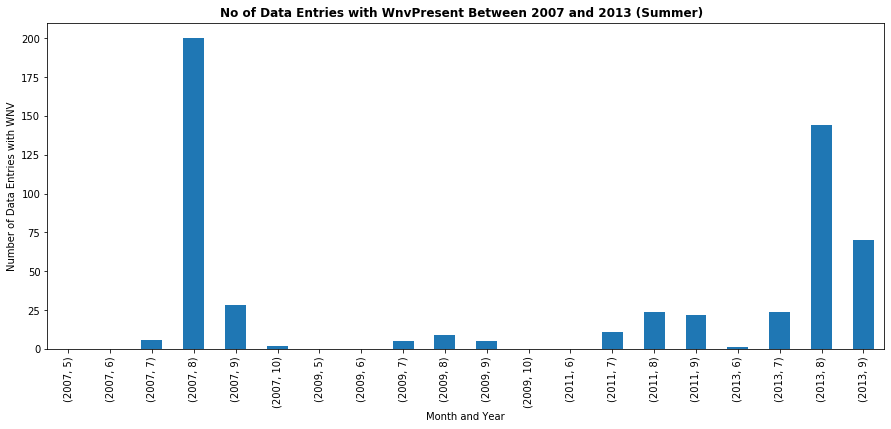

In [72]:
# Overview of the number of traps with WnvPresent across the summer months from 2007 to 2013
weather_eda1.groupby(['year','month']).wnvpresent.sum().plot(kind='bar', figsize=(15,6))
plt.title('No of Data Entries with WnvPresent Between 2007 and 2013 (Summer)  ', weight= 'bold')
plt.grid(False)
plt.xlabel('Month and Year')
plt.ylabel('Number of Data Entries with WNV')
plt.show()

- As mention above, the summer months of 2009 saw a cold front which came in from Lake Michigan causing it to have abnormal weather from May to August. This might have played a major to containing the number of moquistos carrying the virus.
- However, in 2011 we only see a slight increase in number of traps with WnvPresent despite temperatures going back to their normal range.
- The number of traps began to rise only 2 years later, in the summer of 2013. Will be checking to see if their any external factors that might have contributed to the decrease in traps.

### EDA - Combined dataset

In [73]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False
df_test['is_spray'] = False

In [74]:
# Very slow cell,change on to False if not running it
# Setting time delta as 30 days.
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
on=False
if on:
    tdelta_min = dt.timedelta(days=0)
    tdelta_max = dt.timedelta(days=30)
    
    for df in [df_train,df_test]:
        # Looping through df with min,max latitudes and longitudes
        for i,spray in min_max_spray.iterrows():
            long_min = spray['longitude_min']
            long_max = spray['longitude_max']
            lat_min = spray['latitude_min']
            lat_max = spray['latitude_max']
        # Looping through train df, checking is latitudes and longitudes lay between min and max
        # and date is the same date or date +30 days of spraying 
            for j,row in df_train.iterrows():
                if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
                    if ((lat_min <= row['latitude'] <= lat_max) &
                        (long_min <= row['longitude'] <= long_max)):
                        df_train.loc[j,'is_spray'] = True

In [75]:
# Checking number of rows in train which were sprayed - train
df_train['is_spray'].value_counts()

False    10506
Name: is_spray, dtype: int64

In [76]:
# Checking number of rows in train which were sprayed - test
df_test['is_spray'].value_counts()

False    116293
Name: is_spray, dtype: int64

In [77]:
# Merging weather and train df
main_df = pd.merge(df_train,df_weather_st1, on=['date','year','month','day'])
main_df_test = pd.merge(df_test,df_weather_st1, on=['date','year','month','day'])

In [78]:
main_df.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
iswnvspecies              0
is_spray                  0
station                   0
tmax                      0
tmin                      0
tavg                      0
depart                    0
dewpoint                  0
wetbulb                   0
heat                      0
cool                      0
sunrise                   0
sunset                    0
codesum                   0
depth                     0
snowfall                  0
preciptotal               0
stnpressure               0
sealevel                  0
resultspeed               0
resultdir           

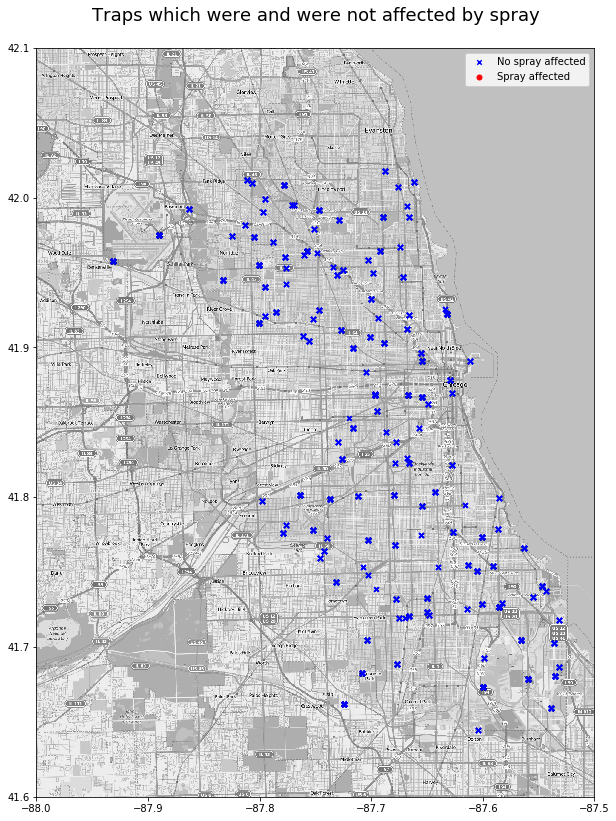

In [79]:
# Plotting traps which were and were not affected by spray
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show();

**Comment**

From the map above it is seen that only some areas were affected by spray.

**Comment**

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

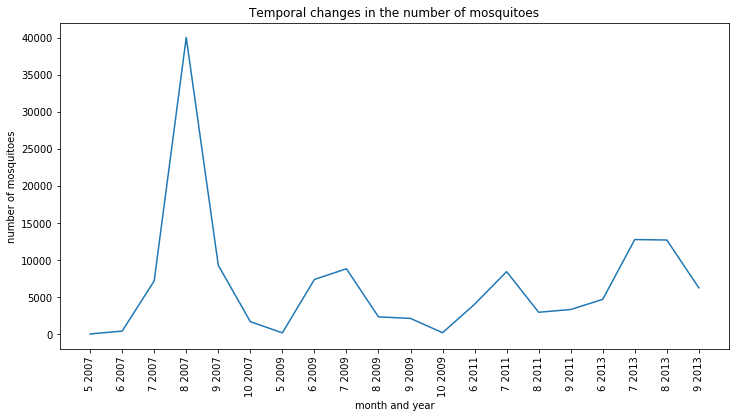

In [80]:
# Visualisation of temporal trend of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes');
plt.ylabel('number of mosquitoes')
plt.xlabel('month and year');

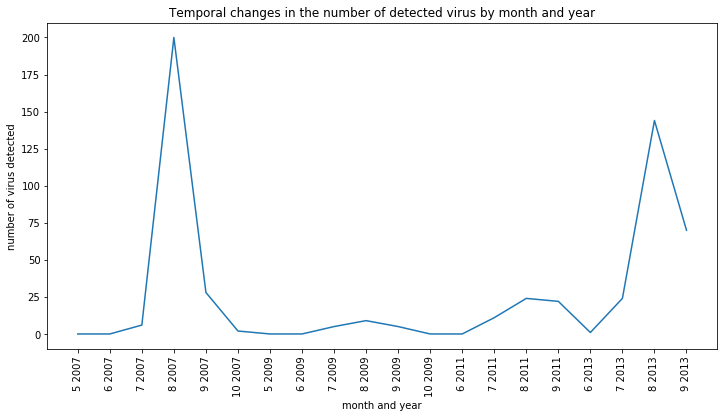

In [81]:
# Plot total count of traps with virus per month over time
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year');
plt.ylabel('number of virus detected')
plt.xlabel('month and year');

**Comment**

The linegraph illustrate that high number of virus was detected in month 8.

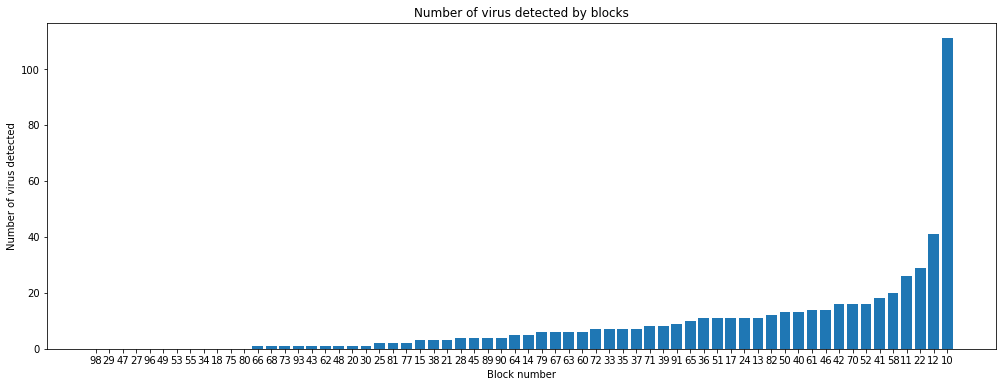

In [82]:
# Plotting presence of the virus on each block
plt.figure(figsize=(17,6))
block_virus = main_df.groupby('block')['wnvpresent'].sum().sort_values()
plt.bar(range(len(main_df['block'].unique())), block_virus)
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=block_virus.index);

**Comment**

The bar graph showed that in traps located in block 10, the virus was detected much frequently than in other locations.

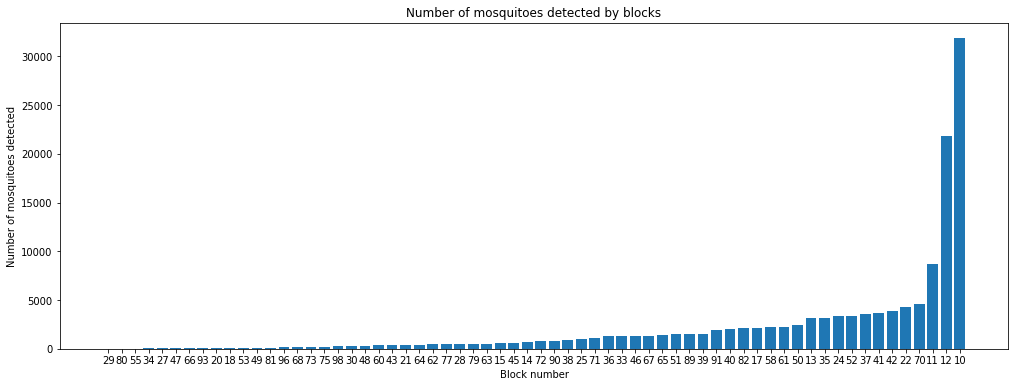

In [83]:
# Plotting number of mosquitoes caught on each block
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum().sort_values())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),
           labels=main_df.groupby('block')['nummosquitos'].sum().sort_values().index);

**Comment**

It can be seen that 10th and 12th block have the anomaly high number of virus detected and number of mosquitoes.

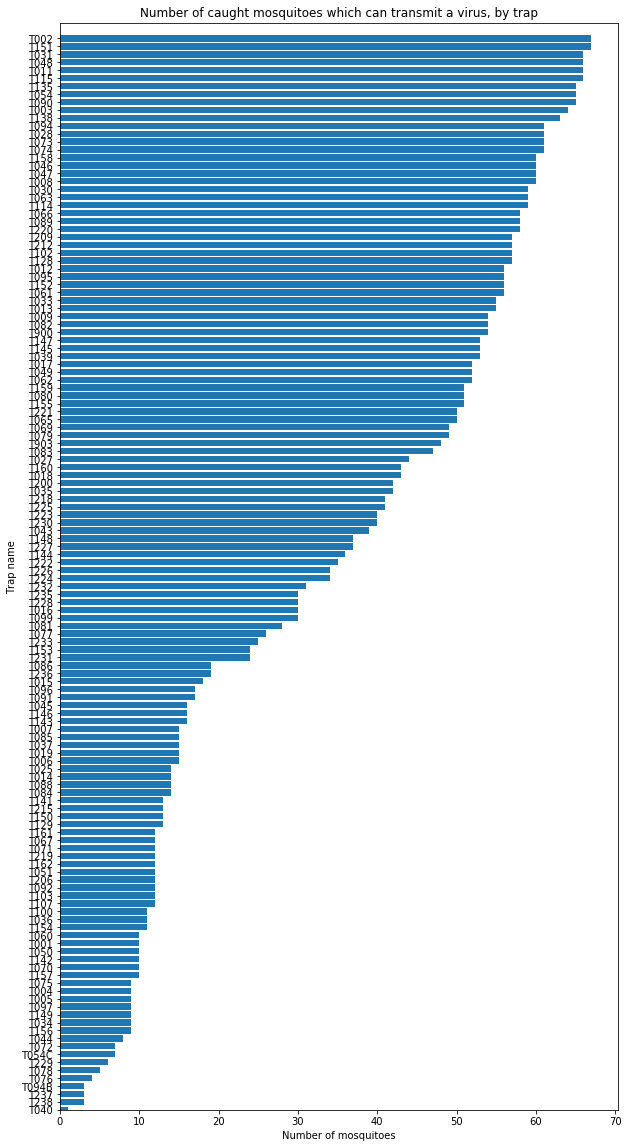

In [84]:
# number of mosquitoes species carry a virus by traps
bin = np.arange(137)
plt.figure(figsize=(10,20))
grouped = df_train_bydate_trap.groupby('trap')['iswnvspecies'].sum()
grouped.sort_values(inplace=True)
plt.barh(grouped.index,grouped.values)
plt.yticks(range(len(grouped.index)),labels=grouped.index)
plt.ylim([0,bin.size])
plt.title('Number of caught mosquitoes which can transmit a virus, by trap')
plt.xlabel('Number of mosquitoes')
plt.ylabel('Trap name');

**Comment**

It can be seen that some traps caught more mosquitoes than others.

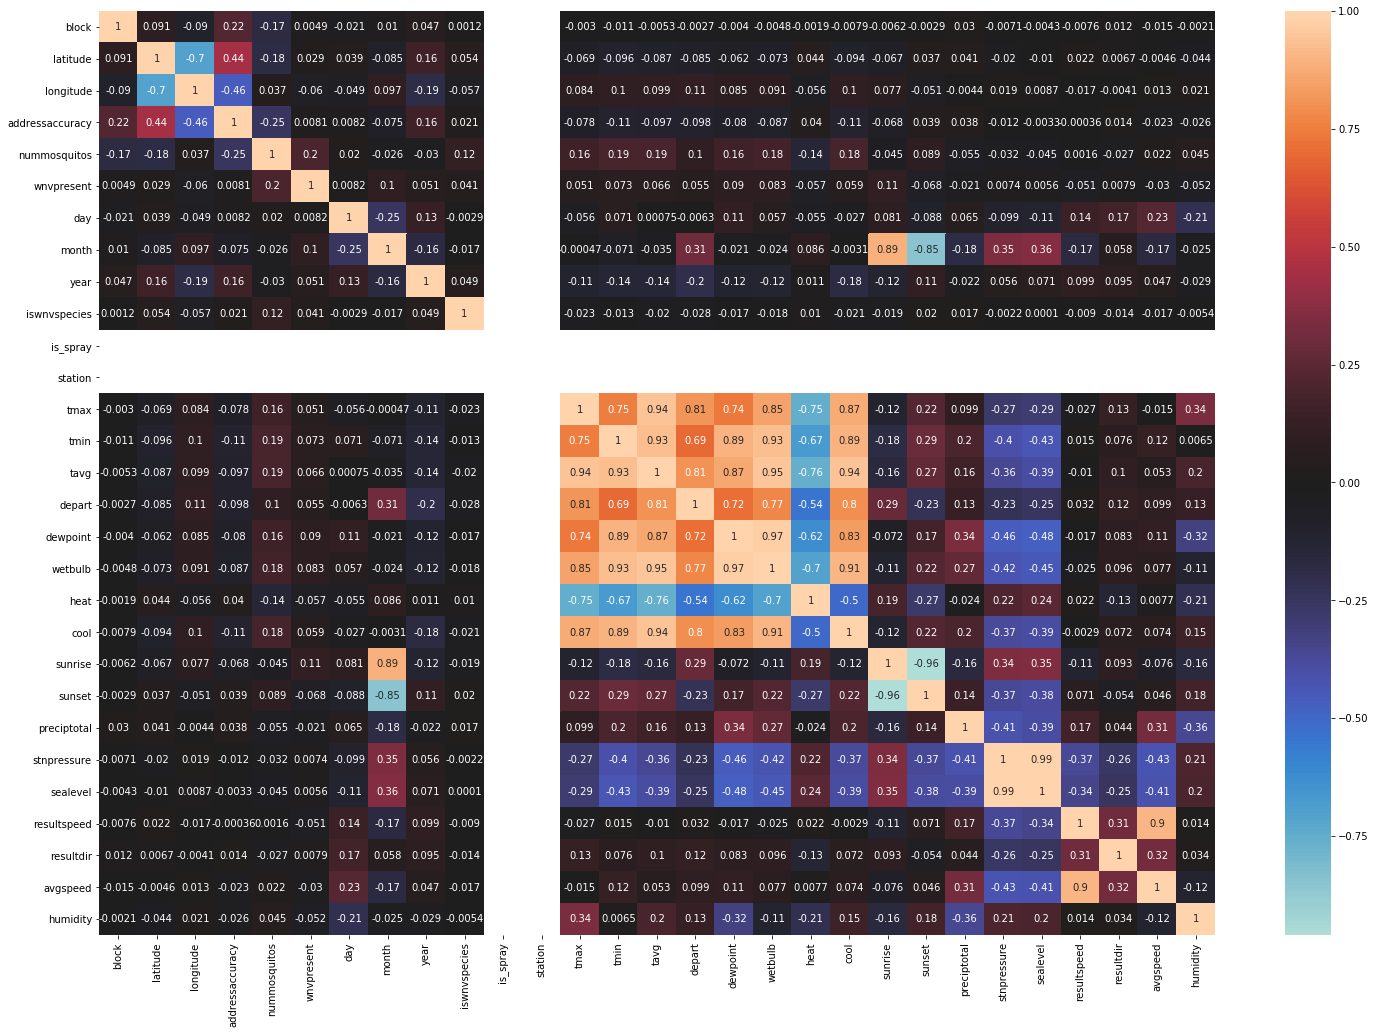

In [85]:
# Plotting intercorrelational matrix
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

**Comment**

We can see that there are not any features which correlate with the target variable (wnvpresent). It can be due to categorical type of target variable and further research is required. 

It is also noticeable that many of weather features intercorrelate.

In [86]:
# separating rows with detected and undetected virus
false_virus_df = main_df[main_df['wnvpresent']==0]
true_virus_df = main_df[main_df['wnvpresent']==1]

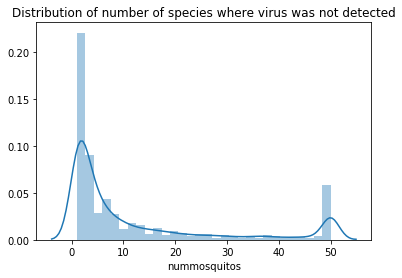

In [87]:
# looking for distribution of number of species where virus was not detected
sns.distplot(false_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was not detected');

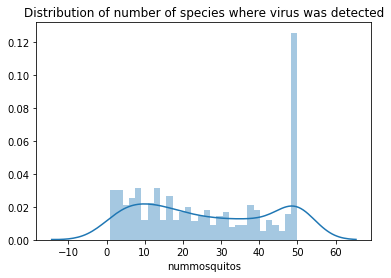

In [88]:
# looking for distribution of number of species where virus was detected
sns.distplot(true_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was detected');

**Comment**

Two distribution plots showed that if the virus is not present - number of mosquities mostly between 0 and 10. But is the virus is present - number of mosquitoes closer to 50.

In [89]:
# Description of cells where the virus is and is not present
false_virus_df_descr = false_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
true_virus_df_descr = true_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
false_virus_df_descr.columns = [col + '_no' for col in false_virus_df_descr.columns]
true_virus_df_descr.columns = [col + '_vir' for col in true_virus_df_descr.columns]
description_df = pd.concat([false_virus_df_descr,true_virus_df_descr],axis=1)
description_df = description_df.reindex(sorted(description_df.columns), axis=1)

description_df

,50%_no,50%_vir,count_no,count_vir,max_no,max_vir,mean_no,mean_vir,min_no,min_vir,std_no,std_vir
block,33.000000,36.000000,9955.0,551.0,98.000000,93.000000,35.659869,36.192377,10.000000,10.000000,24.326517,24.589118
latitude,41.846075,41.903002,9955.0,551.0,42.017430,42.011601,41.840378,41.854891,41.644612,41.644612,0.112269,0.120243
longitude,-87.694259,-87.725057,9955.0,551.0,-87.531635,-87.531635,-87.698538,-87.724663,-87.930995,-87.930995,0.095880,0.104362
addressaccuracy,8.000000,8.000000,9955.0,551.0,9.000000,9.000000,7.816775,7.869328,3.000000,3.000000,1.455860,1.399085
nummosquitos,4.000000,24.000000,9955.0,551.0,50.000000,50.000000,12.106479,26.350272,1.000000,1.000000,15.745767,17.089997
wnvpresent,0.000000,1.000000,9955.0,551.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
day,15.000000,15.000000,9955.0,551.0,31.000000,31.000000,15.324159,15.653358,1.000000,1.000000,8.922370,8.511467
month,8.000000,8.000000,9955.0,551.0,10.000000,10.000000,7.667403,8.147005,5.000000,6.000000,1.083410,0.557743
year,2009.000000,2011.000000,9955.0,551.0,2013.000000,2013.000000,2009.548066,2010.085299,2007.000000,2007.000000,2.323664,2.811338
iswnvspecies,1.000000,1.000000,9955.0,551.0,1.000000,1.000000,0.968358,1.000000,0.000000,1.000000,0.175055,0.000000


**Comment**

From the table above it is clear that some columns nummosquitos, tmin, tmax, dewpoint, wetbulb, heat, cool, sunrise, sunset, preciptotal, avgspeed have different statistics with regards to the presence of the virus.

In [90]:
# Creating a function for adding delay (14 day) weather
def add_tavg_14day(df):
    tdelta = dt.timedelta(days=14)
    df['date_delay'] = df['date'].map(lambda x:x+ tdelta)
    df = pd.merge(df,df_weather_st1[['date','tavg','wetbulb']],left_on='date_delay',right_on='date')
    df.drop(columns=['date_delay','tavg_x','wetbulb_x','date_y'],inplace=True)
    df.rename(columns={'wetbulb_y':'wetbulb','tavg_y':'tavg','date_x':'date'},inplace=True)
    return df

In [91]:
# Applying function for train and test dfs
main_df = add_tavg_14day(main_df)
main_df_test = add_tavg_14day(main_df_test)

In [92]:
wnv_df = main_df[main_df.wnvpresent == 1]
map_wnv = folium.Map(location=[wnv_df.latitude.mean(), wnv_df.longitude.mean()], zoom_start=12,
               tiles='Stamen Terrain')

for _, row in wnv_df.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        dates=row.date,
        radius=5,
        popup=row.street,
        color='darkred',
        fill=True,
        fill_colour='darkred'
    ).add_to(map_wnv)
    
map_wnv

- Overview of the WnvPresent hotspots by traps/neigbhorhood across Chicago
- Did 2, maps 1 is in heatmap format below

In [93]:
def generateBaseMap(default_location=[wnv_df.latitude.mean(), wnv_df.longitude.mean()], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# df_heatmap_wnv = df_heatmap[df_heatmap.wnvpresent==1].copy()
base_map = generateBaseMap()
HeatMap(data=wnv_df[['latitude', 'longitude', 'wnvpresent']].groupby
        (['latitude','longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=9).add_to(base_map)

base_map

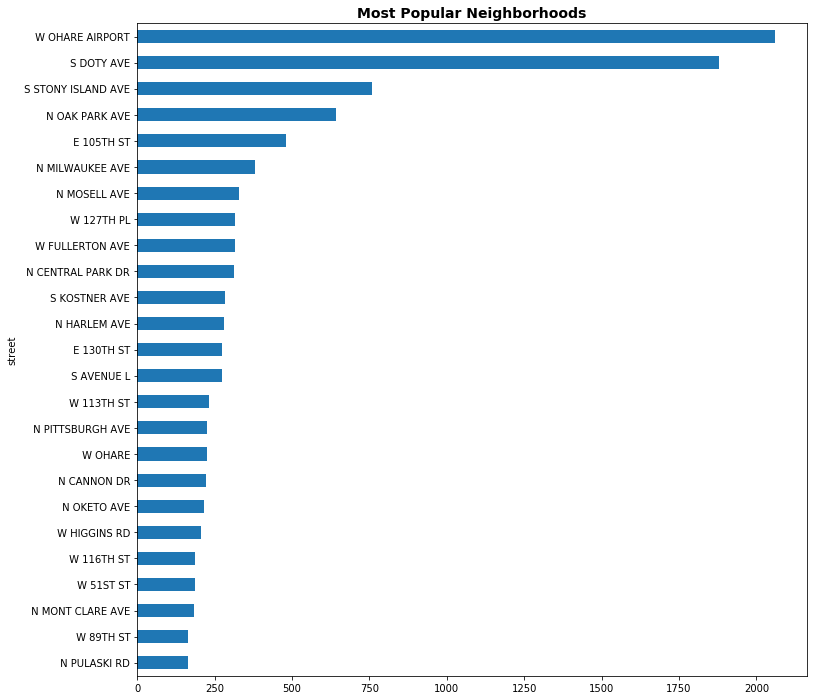

In [94]:
# Location, Location, Location
# Which is the neighborhood with the highest west nile virus present
wnv_df.groupby('street').nummosquitos.sum().sort_values().tail(25).plot(kind='barh', figsize= (12, 12))
plt.title('Most Popular Neighborhoods', size= 14, weight='bold')
plt.grid(False)
plt.show()

The top 5 neighborhoods with a high number of WnvPresent are W OHARE Airport, S Doty Avenue, S Stony Island Avenue, N Oak Park Avenue and E 105th Street.

The below heatmap shows the hotspots for each trap/neighbhorhood by year

In [95]:
heatmap_year = []
for y in wnv_df.year.sort_values().unique():

    heatmap_year.append(wnv_df.loc[y == wnv_df.year, ["latitude", "longitude"]]
                        .groupby(["latitude", "longitude"]).sum().reset_index().values.tolist())
    
base_map = generateBaseMap(default_zoom_start=8)
HeatMapWithTime(heatmap_year, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, 
                max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

In [96]:
# Saving clean datasets
main_df.to_csv('../datasets/main_df.csv',index=False)
main_df_test.to_csv('../datasets/main_df_test.csv',index=False)

In [97]:
# Uploading clean datasets
main_df = pd.read_csv('../datasets/main_df.csv')
main_df_test = pd.read_csv('../datasets/main_df_test.csv')
# Changing date columns to datetime type
main_df['date'] = pd.to_datetime(main_df['date'])
main_df_test['date'] = pd.to_datetime(main_df_test['date'])

## Feature Selection and Modeling

### Baseline Model

In [509]:
main_df['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

**Comment**

From the baseline model, a sub group of a trap has a 94.7 percent chance of catching mosquitoes that carry the West Nile Virus

We will explore various approaches to feature selection and modeling.

### Approach A

In [510]:
# Make copy of main dataframe
df_main_A = main_df.copy()

In [511]:
# Arbitary selection of relevant features for modelling
df_main_A = df_main_A[['block','month', 'iswnvspecies','is_spray',
                       'tavg','humidity','preciptotal','wnvpresent']]

In [512]:
# Set boolean column to int
df_main_A.loc[:,'is_spray'] = df_main_A.loc[:,'is_spray'].astype(int)

In [513]:
# Verify column is not int
df_main_A.dtypes

block             int64
month             int64
iswnvspecies      int64
is_spray          int32
tavg            float64
humidity        float64
preciptotal     float64
wnvpresent        int64
dtype: object

In [514]:
df_main_A = pd.get_dummies(df_main_A,columns=['block','month'],drop_first=True)

In [515]:
df_main_A.head()

,iswnvspecies,is_spray,tavg,humidity,preciptotal,wnvpresent,block_11,block_12,block_13,block_14,...,block_90,block_91,block_93,block_96,block_98,month_6,month_7,month_8,month_9,month_10
0,1,0,22.78,8.89,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,22.78,8.89,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,22.78,8.89,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,22.78,8.89,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,22.78,8.89,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [516]:
X = df_main_A.drop('wnvpresent',axis=1)
y = df_main_A['wnvpresent']

**Comment**

Due to very low number of incidences of West Nile virus being present (value 1), there is a need to perform resampling.
Since there is a limited amount of data, we will be performing oversampling on the minority class.

In [517]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42)

#### Oversampling minority class

In [518]:
X = pd.concat([X_train, y_train], axis=1)

In [519]:
X_maj = X[X['wnvpresent']==0]
X_min = X[X['wnvpresent']==1]

In [520]:
X_min_os = resample(X_min,
                    replace=True,
                    n_samples=len(X_maj),
                    random_state=42)

In [521]:
X_os = pd.concat([X_maj, X_min_os])

In [522]:
X_os.wnvpresent.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [523]:
X_train = X_os.drop('wnvpresent',axis=1)
y_train = X_os.wnvpresent

#### Logistic regression

In [524]:
# Define parameters
Cs = [0.01, 0.1, 1, 10, 100]

In [525]:
# Perform CV to look for best scoring parameters
lr = LogisticRegressionCV(Cs=Cs,scoring='roc_auc',max_iter=2000)

In [526]:
lr.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100], class_weight=None, cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=2000, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [527]:
lr.score(X_train,y_train)

0.7991810306194582

In [528]:
lr.score(X_test,y_test)

0.7639104814808345

In [529]:
pred = lr.predict(X_test)

In [530]:
confusion_matrix(y_test,pred)

array([[1527,  962],
       [  26,  112]], dtype=int64)

In [531]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

In [532]:
print('Accuracy: '.rjust(40) + f'{round((tp + tn) / (tp + fp + tn + fn),2)}')
print('Sensitivity: '.rjust(40) + f'{round((tp) / (tp + fn),2)}')
print('Specificity: '.rjust(40) + f'{round((tn) / (fp + tn),2)}')
print('Precision: '.rjust(40) + f'{round((tp) / (tp + fp),2)}')

                              Accuracy: 0.62
                           Sensitivity: 0.81
                           Specificity: 0.61
                             Precision: 0.1


In [533]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':[i[1] for i in lr.predict_proba(X_test)]})

# Calculate ROC AUC

roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.7639104814808345

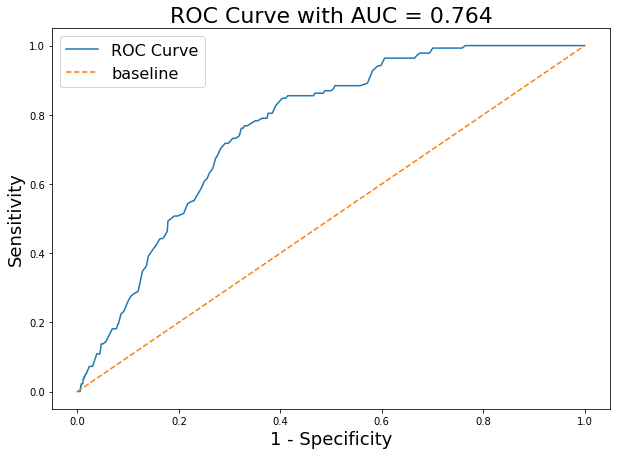

In [534]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

#### Interpreting relevant features

In [535]:
df_features = pd.DataFrame({'features': list(X_test.columns), 'Coefficient': list(lr.coef_[0])})

In [536]:
# Top 5 features
df_features.sort_values('Coefficient', ascending=False).head(8)

,features,Coefficient
0,iswnvspecies,7.217091
70,month_8,5.438124
71,month_9,5.080694
69,month_7,3.409144
49,block_66,2.549074
72,month_10,2.066059
33,block_46,0.920137
61,block_82,0.918919


In [537]:
# Bottom 5 features
df_features.sort_values('Coefficient').head(10)

,features,Coefficient
11,block_18,-6.918825
36,block_49,-6.792998
40,block_53,-6.792700
67,block_98,-6.605970
66,block_96,-6.586758
56,block_75,-6.498762
34,block_47,-6.287737
17,block_27,-6.199118
59,block_80,-6.039065
22,block_34,-4.767685


####  Random Forest with GridSearch

In [538]:
rf = RandomForestClassifier()

In [539]:
rf_param = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : [None,1,2,3,4,5]
}

gs = GridSearchCV(rf, param_grid=rf_param,cv=5,scoring='roc_auc')

In [540]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [541]:
gs.best_score_

0.9501880195031192

In [542]:
gs.score(X_train,y_train)

0.96305387889695

In [543]:
gs.score(X_test,y_test)

0.7380692438031689

In [544]:
pred = gs.predict(X_test)

In [545]:
confusion_matrix(y_test,pred)

array([[2023,  466],
       [  65,   73]], dtype=int64)

In [546]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

In [547]:
print('Accuracy: '.rjust(40) + f'{round((tp + tn) / (tp + fp + tn + fn),2)}')
print('Sensitivity: '.rjust(40) + f'{round((tp) / (tp + fn),2)}')
print('Specificity: '.rjust(40) + f'{round((tn) / (fp + tn),2)}')
print('Precision: '.rjust(40) + f'{round((tp) / (tp + fp),2)}')

                              Accuracy: 0.8
                           Sensitivity: 0.53
                           Specificity: 0.81
                             Precision: 0.14


In [548]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs' : [i[1] for i in gs.predict_proba(X_test)]})

# Calculate ROC AUC
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.7380692438031689

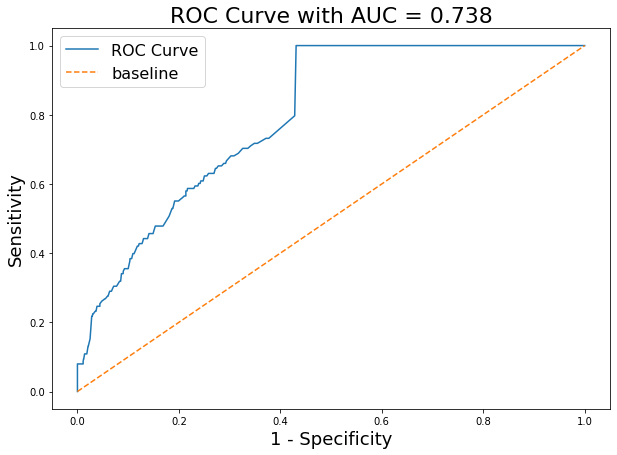

In [549]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
tpr_values.insert(0,1)
tpr_values.append(0)
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values.insert(0,1)
fpr_values.append(0)

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

#### Model Evaluation

Comparing the two models, logistic regression performs worse in terms of accuracy, but better in terms of sensitivity.
As for this problem, having a higher sensitivity score is preferred since it will mean a lower rate of false negatives.
Therefore, for this approach, we will make a submission using the logistic regression method.

#### Submission data generation

In [550]:
main_df_test_A = main_df_test[['block','month', 'iswnvspecies','is_spray',
                               'tavg', 'humidity','preciptotal']]

In [551]:
main_df_test_A = pd.get_dummies(main_df_test_A,columns=['block','month'],drop_first=True)

In [552]:
pred = lr.predict(main_df_test_A)

In [553]:
# Create dataframe with submission format
df_sub = pd.DataFrame({'Id': main_df_test['id'].values, 'WnvPresent' : pred})

In [554]:
df_sub.head()

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [555]:
df_sub.to_csv('../datasets/submission_a.csv',index=False)

Kaggle score: 0.61725

---

### Approach B

In [556]:
# Obtain top WNV hotspots for streets and traps

grouped_street = df_train_bydate_trap.groupby('street')['wnvpresent'].sum()
grouped_street.sort_values(inplace=True)

grouped_trap = df_train_bydate_trap.groupby('trap')['wnvpresent'].sum()
grouped_trap.sort_values(inplace=True)

In [557]:
# Copy DF
main_df_b = main_df.copy()

# Set boolean column to int
main_df_b['is_spray'] = [int(row == True) for row in main_df_b['is_spray']]

In [558]:
# Select key features for our model fitting

feature_columns = ['month', 'year', 'block', 'is_spray', 
             'dewpoint','wnvpresent', 'sunrise','sunset', 
             'latitude', 'longitude', 'addressaccuracy', 
             'tavg','tmin', 'tmax']

In [559]:
# Select species that carry WNV

top_species = ['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS']

# Select the top 20 traps that have the highest ratio of WNV

top_traps = grouped_trap.sort_values(ascending=False)
top_traps = top_traps.index[:20].tolist()

# Select the top 5 streets that have the highest ratio of WNV

top_street = grouped_street.sort_values(ascending=False)
top_street = top_street.index[:5].tolist()

In [560]:
# Create dummy variables of top species, traps and streets

species_dummy = pd.get_dummies(main_df_b['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(main_df_b['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(main_df_b['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

traps_dummy.head()

,T900,T003,T002,T115,T225,T011,T013,T223,T008,T138,T114,T082,T030,T090,T061,T151,T128,T009,T903,T221
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [561]:
# Select key features

main_df_b = main_df_b.loc[:, feature_columns]
main_df_b.head()

,month,year,block,is_spray,dewpoint,wnvpresent,sunrise,sunset,latitude,longitude,addressaccuracy,tavg,tmin,tmax
0,5,2007,41,0,14.44,0,421.0,1917.0,41.954690,-87.800991,9,22.78,15.56,31.11
1,5,2007,41,0,14.44,0,421.0,1917.0,41.954690,-87.800991,9,22.78,15.56,31.11
2,5,2007,62,0,14.44,0,421.0,1917.0,41.994991,-87.769279,9,22.78,15.56,31.11
3,5,2007,79,0,14.44,0,421.0,1917.0,41.974089,-87.824812,8,22.78,15.56,31.11
4,5,2007,79,0,14.44,0,421.0,1917.0,41.974089,-87.824812,8,22.78,15.56,31.11


In [562]:
main_df_b = pd.concat([main_df_b,traps_dummy],axis=1)
main_df_b = pd.concat([main_df_b,street_dummy],axis=1)
main_df_b = pd.concat([main_df_b,species_dummy],axis=1)
main_df_b.head()

,month,year,block,is_spray,dewpoint,wnvpresent,sunrise,sunset,latitude,longitude,...,T903,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS
0,5,2007,41,0,14.44,0,421.0,1917.0,41.954690,-87.800991,...,0,0,0,1,0,0,0,1,0,0
1,5,2007,41,0,14.44,0,421.0,1917.0,41.954690,-87.800991,...,0,0,0,1,0,0,0,0,1,0
2,5,2007,62,0,14.44,0,421.0,1917.0,41.994991,-87.769279,...,0,0,0,0,0,0,0,0,1,0
3,5,2007,79,0,14.44,0,421.0,1917.0,41.974089,-87.824812,...,0,0,0,0,0,0,0,1,0,0
4,5,2007,79,0,14.44,0,421.0,1917.0,41.974089,-87.824812,...,0,0,0,0,0,0,0,0,1,0


In [563]:
main_df_b['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

In [564]:
feature_columns.extend(top_traps)
feature_columns.extend(top_street)
feature_columns.extend(top_species)
feature_columns

['month',
 'year',
 'block',
 'is_spray',
 'dewpoint',
 'wnvpresent',
 'sunrise',
 'sunset',
 'latitude',
 'longitude',
 'addressaccuracy',
 'tavg',
 'tmin',
 'tmax',
 'T900',
 'T003',
 'T002',
 'T115',
 'T225',
 'T011',
 'T013',
 'T223',
 'T008',
 'T138',
 'T114',
 'T082',
 'T030',
 'T090',
 'T061',
 'T151',
 'T128',
 'T009',
 'T903',
 'T221',
 ' W OHARE AIRPORT',
 ' N OAK PARK AVE',
 ' N MILWAUKEE AVE',
 ' S DOTY AVE',
 ' S KOSTNER AVE',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX PIPIENS']

In [565]:
X = main_df_b[feature_columns]
y = main_df_b['wnvpresent']

X.drop(columns='wnvpresent', inplace=True)

X.shape

(10506, 41)

In [566]:
y.shape

(10506,)

In [567]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25, stratify=y)

In [568]:
y_train.value_counts()

0    7466
1     413
Name: wnvpresent, dtype: int64

In [569]:
X = pd.concat([X_train, y_train], axis=1)
X.head()

,month,year,block,is_spray,dewpoint,sunrise,sunset,latitude,longitude,addressaccuracy,...,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS,wnvpresent
10140,9,2013,82,0,14.44,522.0,1819.0,41.743402,-87.731435,8,...,0,0,0,0,0,1,0,0,1,1
7737,9,2011,10,0,15.00,528.0,1809.0,41.899230,-87.716788,9,...,0,0,0,0,0,0,0,0,1,0
8079,9,2011,71,0,5.00,547.0,1735.0,41.766202,-87.562889,9,...,0,0,0,0,0,0,1,0,0,0
2449,8,2007,10,0,21.67,506.0,1843.0,41.726465,-87.585413,5,...,0,0,0,0,0,0,0,0,1,0
449,7,2007,11,0,20.00,432.0,1924.0,41.862292,-87.648860,8,...,0,0,0,0,0,0,0,0,1,0


In [570]:
# separate minority and majority classes
wnv_false = X[X.wnvpresent==0]
wnv_true = X[X.wnvpresent==1]

# upsample minority
wnv_upsampled = resample(wnv_true,
                          replace=True, # sample with replacement
                          n_samples=len(wnv_false), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([wnv_false, wnv_upsampled])

# check new wnvpresent counts
upsampled.wnvpresent.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [571]:
# update our training data with the upsampled data

X_train = upsampled.drop('wnvpresent',axis=1)
y_train = upsampled.wnvpresent

In [572]:
# Baseline accuracy 50% due to upsampling

y_train.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [573]:
X_train.shape

(14932, 41)

In [574]:
y_train.shape

(14932,)

#### Testing Various other models

In [575]:
# Fit various models

# Decision Trees
rfc = RandomForestClassifier(random_state=42).fit(X_train, y_train)
et = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

# Boosting
gboost = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
adaboost = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)

# KNearestNeighbors
knn = KNeighborsClassifier().fit(X_train, y_train)

In [576]:
# Observe general train / test accuracy for all models
# Extra Trees perform the best with 86% accuracy for our validation data
# All models appear to be overfit

print ('rfc train : {}'.format(rfc.score(X_train, y_train)))
print ('rfc test : {}'.format(rfc.score(X_test, y_test)))
print ('')
print ('et train : {}'.format(et.score(X_train, y_train)))
print ('et test : {}'.format(et.score(X_test, y_test)))
print ('')
print ('adaboost train : {}'.format(adaboost.score(X_train, y_train)))
print ('adaboost test : {}'.format(adaboost.score(X_test, y_test)))
print ('')
print ('gboost train : {}'.format(gboost.score(X_train, y_train)))
print ('gboost test : {}'.format(gboost.score(X_test, y_test)))
print ('')
print ('lr train : {}'.format(lr.score(X_train, y_train)))
print ('lr test : {}'.format(lr.score(X_test, y_test)))
print ('')
print ('knn train : {}'.format(knn.score(X_train, y_train)))
print ('knn test : {}'.format(knn.score(X_test, y_test)))

rfc train : 0.9727431020626842
rfc test : 0.8972211648267986

et train : 0.9727431020626842
et test : 0.898743814236772

adaboost train : 0.7802035896062148
adaboost test : 0.7460982108869433

gboost train : 0.8276185373694079
gboost test : 0.7655119908641035

lr train : 0.73660594695955
lr test : 0.701941377997716

knn train : 0.9393919099919635
knn test : 0.8313665778454511


In [577]:
tn, fp, fn, tp = confusion_matrix(y_test, et.predict(X_test)).ravel()

print("Extra Trees Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Extra Trees Confusion Matrix

True Negatives: 2330
False Positives: 159
False Negatives: 107
True Positives: 31

Precision: 0.16
Recall: 0.22


In [578]:
tn, fp, fn, tp = confusion_matrix(y_test, knn.predict(X_test)).ravel()

print("K-Nearest Neighbors Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

K-Nearest Neighbors Confusion Matrix

True Negatives: 2118
False Positives: 371
False Negatives: 72
True Positives: 66

Precision: 0.15
Recall: 0.48


In [579]:
tn, fp, fn, tp = confusion_matrix(y_test, gboost.predict(X_test)).ravel()

print("Gradient Boost Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Gradient Boost Confusion Matrix

True Negatives: 1910
False Positives: 579
False Negatives: 37
True Positives: 101

Precision: 0.15
Recall: 0.73


In [580]:
gboost = GradientBoostingClassifier(random_state=42, n_estimators=100).fit(X_train, y_train)
gb_pred = gboost.predict(X_test)

In [581]:
pd.DataFrame(confusion_matrix(y_test, gb_pred))

,0,1
0,1910,579
1,37,101


#### ROC AUC

In [582]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gboost.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC

roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8280797829289452

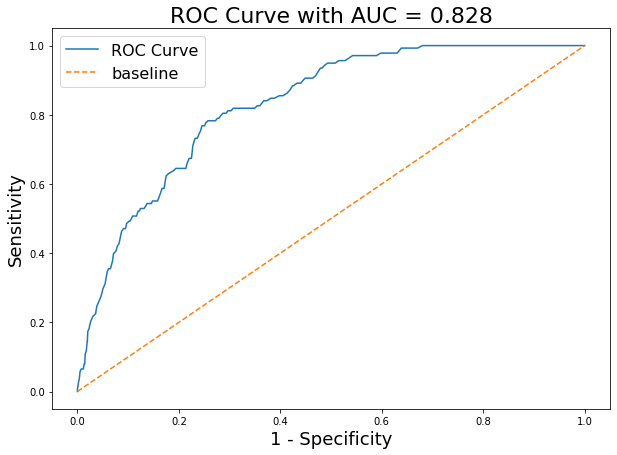

In [583]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [584]:
df_test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'day', 'month', 'year', 'iswnvspecies', 'is_spray'],
      dtype='object')

In [585]:
df_test.shape

(116293, 16)

In [586]:
main_df_test_b = main_df_test.copy()

In [587]:
species_dummy = pd.get_dummies(main_df_test_b['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(main_df_test_b['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(main_df_test_b['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

main_df_test_b = pd.concat([main_df_test_b,traps_dummy],axis=1)
main_df_test_b = pd.concat([main_df_test_b,street_dummy],axis=1)
main_df_test_b = pd.concat([main_df_test_b,species_dummy],axis=1)

# Select key features
test_feature_columns = feature_columns
test_feature_columns.remove('wnvpresent')

main_df_test_b = main_df_test_b[test_feature_columns]

main_df_test_b.head()

,month,year,block,is_spray,dewpoint,sunrise,sunset,latitude,longitude,addressaccuracy,...,T903,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS
0,6,2008,41,False,13.33,416.0,1926.0,41.95469,-87.800991,9,...,0,0,0,1,0,0,0,1,0,0
1,6,2008,41,False,13.33,416.0,1926.0,41.95469,-87.800991,9,...,0,0,0,1,0,0,0,0,1,0
2,6,2008,41,False,13.33,416.0,1926.0,41.95469,-87.800991,9,...,0,0,0,1,0,0,0,0,0,1
3,6,2008,41,False,13.33,416.0,1926.0,41.95469,-87.800991,9,...,0,0,0,1,0,0,0,0,0,0
4,6,2008,41,False,13.33,416.0,1926.0,41.95469,-87.800991,9,...,0,0,0,1,0,0,0,0,0,0


#### Generate Submission data

In [588]:
# Get our test dataframe with our feature columns
# This is equivalent to 'X' in our training data
feats = main_df_test_b[test_feature_columns]

In [589]:
feats['is_spray']= feats['is_spray'].map({False : 0})

In [590]:
# Perform predictions of WNV Present based on our selected features
# with our Gradient Boosting Model
predictions = gboost.predict(feats)

# Create dataframe with submission format
submission = pd.DataFrame({'Id': main_df_test['id'].values, 'WnvPresent' : predictions})

In [591]:
# Save our dataframe into a csv file for submission
submission.to_csv('../datasets/submission_b.csv',index=False)

# 0.58132 Public Score 0.61498 Private Score

---

## Approach C

In [710]:
main_df_c = main_df.copy()
main_df_test_c = main_df_test.copy()

In [711]:
# Changing trap name to number
# Function for removing letters and converting to int
def str_to_int(x):
    x = re.sub("[a-zA-Z]", "", x)
    return int(x)
main_df_c['trap'] = main_df_c['trap'].map(lambda x: str_to_int(x))
main_df_test_c['trap'] = main_df_test_c['trap'].map(lambda x: str_to_int(x))

In [712]:
main_df_c.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'iswnvspecies',
       'is_spray', 'station', 'tmax', 'tmin', 'depart', 'dewpoint', 'heat',
       'cool', 'sunrise', 'sunset', 'codesum', 'depth', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'humidity', 'tavg', 'wetbulb'],
      dtype='object')

Features which differ based on the presence of WN virus were chosen. One from intercorrelated features were remain based on the dispersion of variation (refer to statistics table in EDA).

In [713]:
X = main_df_c[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb','humidity','is_spray']]
y = main_df_c['wnvpresent']
X_test_submit = main_df_test_c[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb','humidity','is_spray']]

#### Resampling with different methods

In [714]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [715]:
# defining minor and major classes
X_all = pd.concat([X_train, y_train],axis=1)
true_virus = X_all[X_all['wnvpresent']==1]
false_virus = X_all[X_all['wnvpresent']==0]

In [716]:
# Doing undersampling of the majority class
on=True
if on:
    false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([false_virus_downsampled, true_virus])
    features = [col for col in downsampled if col !='wnvpresent']
    X_unders = downsampled[features]
    y_unders = downsampled['wnvpresent']
    # checking counts
    print(downsampled.wnvpresent.value_counts())

1    413
0    413
Name: wnvpresent, dtype: int64


In [717]:
# Doing oversampling of the minority class
# https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
# Separate input features and target

on= False
if on:
    sm = SMOTE(sampling_strategy='minority',random_state=42)
    X_train_sm, y_train_sm = sm.fit_sample(X, y)
    oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
    print(oversempling_smote.wnvpresent.value_counts())


1    9955
0    9955
Name: wnvpresent, dtype: int64


In [718]:
# a combination of over-sampling and under-sampling
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
on= False
if on:
    smt = SMOTETomek(sampling_strategy='all')
    X_smt, y_smt = smt.fit_sample(X, y)
    oversempling_smoteTomek = pd.concat([X_smt, y_smt],axis=1)
    oversempling_smoteTomek.wnvpresent.value_counts()

In [719]:
# Creating function for resamling
def resampling_dataset(how,X_train,y_train,on= True):
    """
    Resamples imbalanced dataset
    
    Takes:
    how (str) : 'under', 'over', 'smote'
    x - df - with features
    y - series - with target
    on - on/of function
    Returns:
    X,y
    """
    if on:
        if how == 'under':
            X = pd.concat([X_train, y_train],axis=1)
            true_virus = X[X['wnvpresent']==1]
            false_virus = X[X['wnvpresent']==0]
            false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

            # combine minority and downsampled majority
            downsampled = pd.concat([false_virus_downsampled, true_virus])
            features = [col for col in downsampled if col !='wnvpresent']
            X_unders = downsampled[features]
            y_unders = downsampled['wnvpresent']
            return X_unders, y_unders
        elif how == 'over':
            sm = SMOTE(sampling_strategy='minority',random_state=42)
            X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
            oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
            return X_train_sm, y_train_sm
        else:
            smt = SMOTETomek(sampling_strategy='all')
            X_smt, y_smt = smt.fit_sample(X_train, y_train)
            return X_smt, y_smt

In [720]:
# Creating a function for boxplots
def subplot_boxplot(dataframe, list_columns,maintitle,blocks,figsize=(10,10)):
    """
    Plots a boxplot of the column which in the list. 
    
    Takes:
    dataframe
    list_columns - (list of str) - list of column's names.
    maintitle - (str) - main title for all scatterplots
    figsize - the custom size of a figure, 10x10 by default.
    blocks - (list of int) - list of block names
    
    Returns:
    Boxplot plot.
    """
    nrows = int(np.ceil(len(list_columns)/3))
    fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=figsize)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_columns):
        dataframe.boxplot(column=column, 
                    by='wnvpresent', ax=ax[i])
        ax[i].set_title(f'Boxplot of {column}\n', fontsize=20)
#         deleting empty subplot if list_of_list_columns is odd
    if len(list_columns)%2 ==0:
        fig.delaxes(ax[len(list_columns)]) 
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
    plt.suptitle(maintitle,fontsize=25)
    fig.subplots_adjust(top=0.95)
    plt.show()

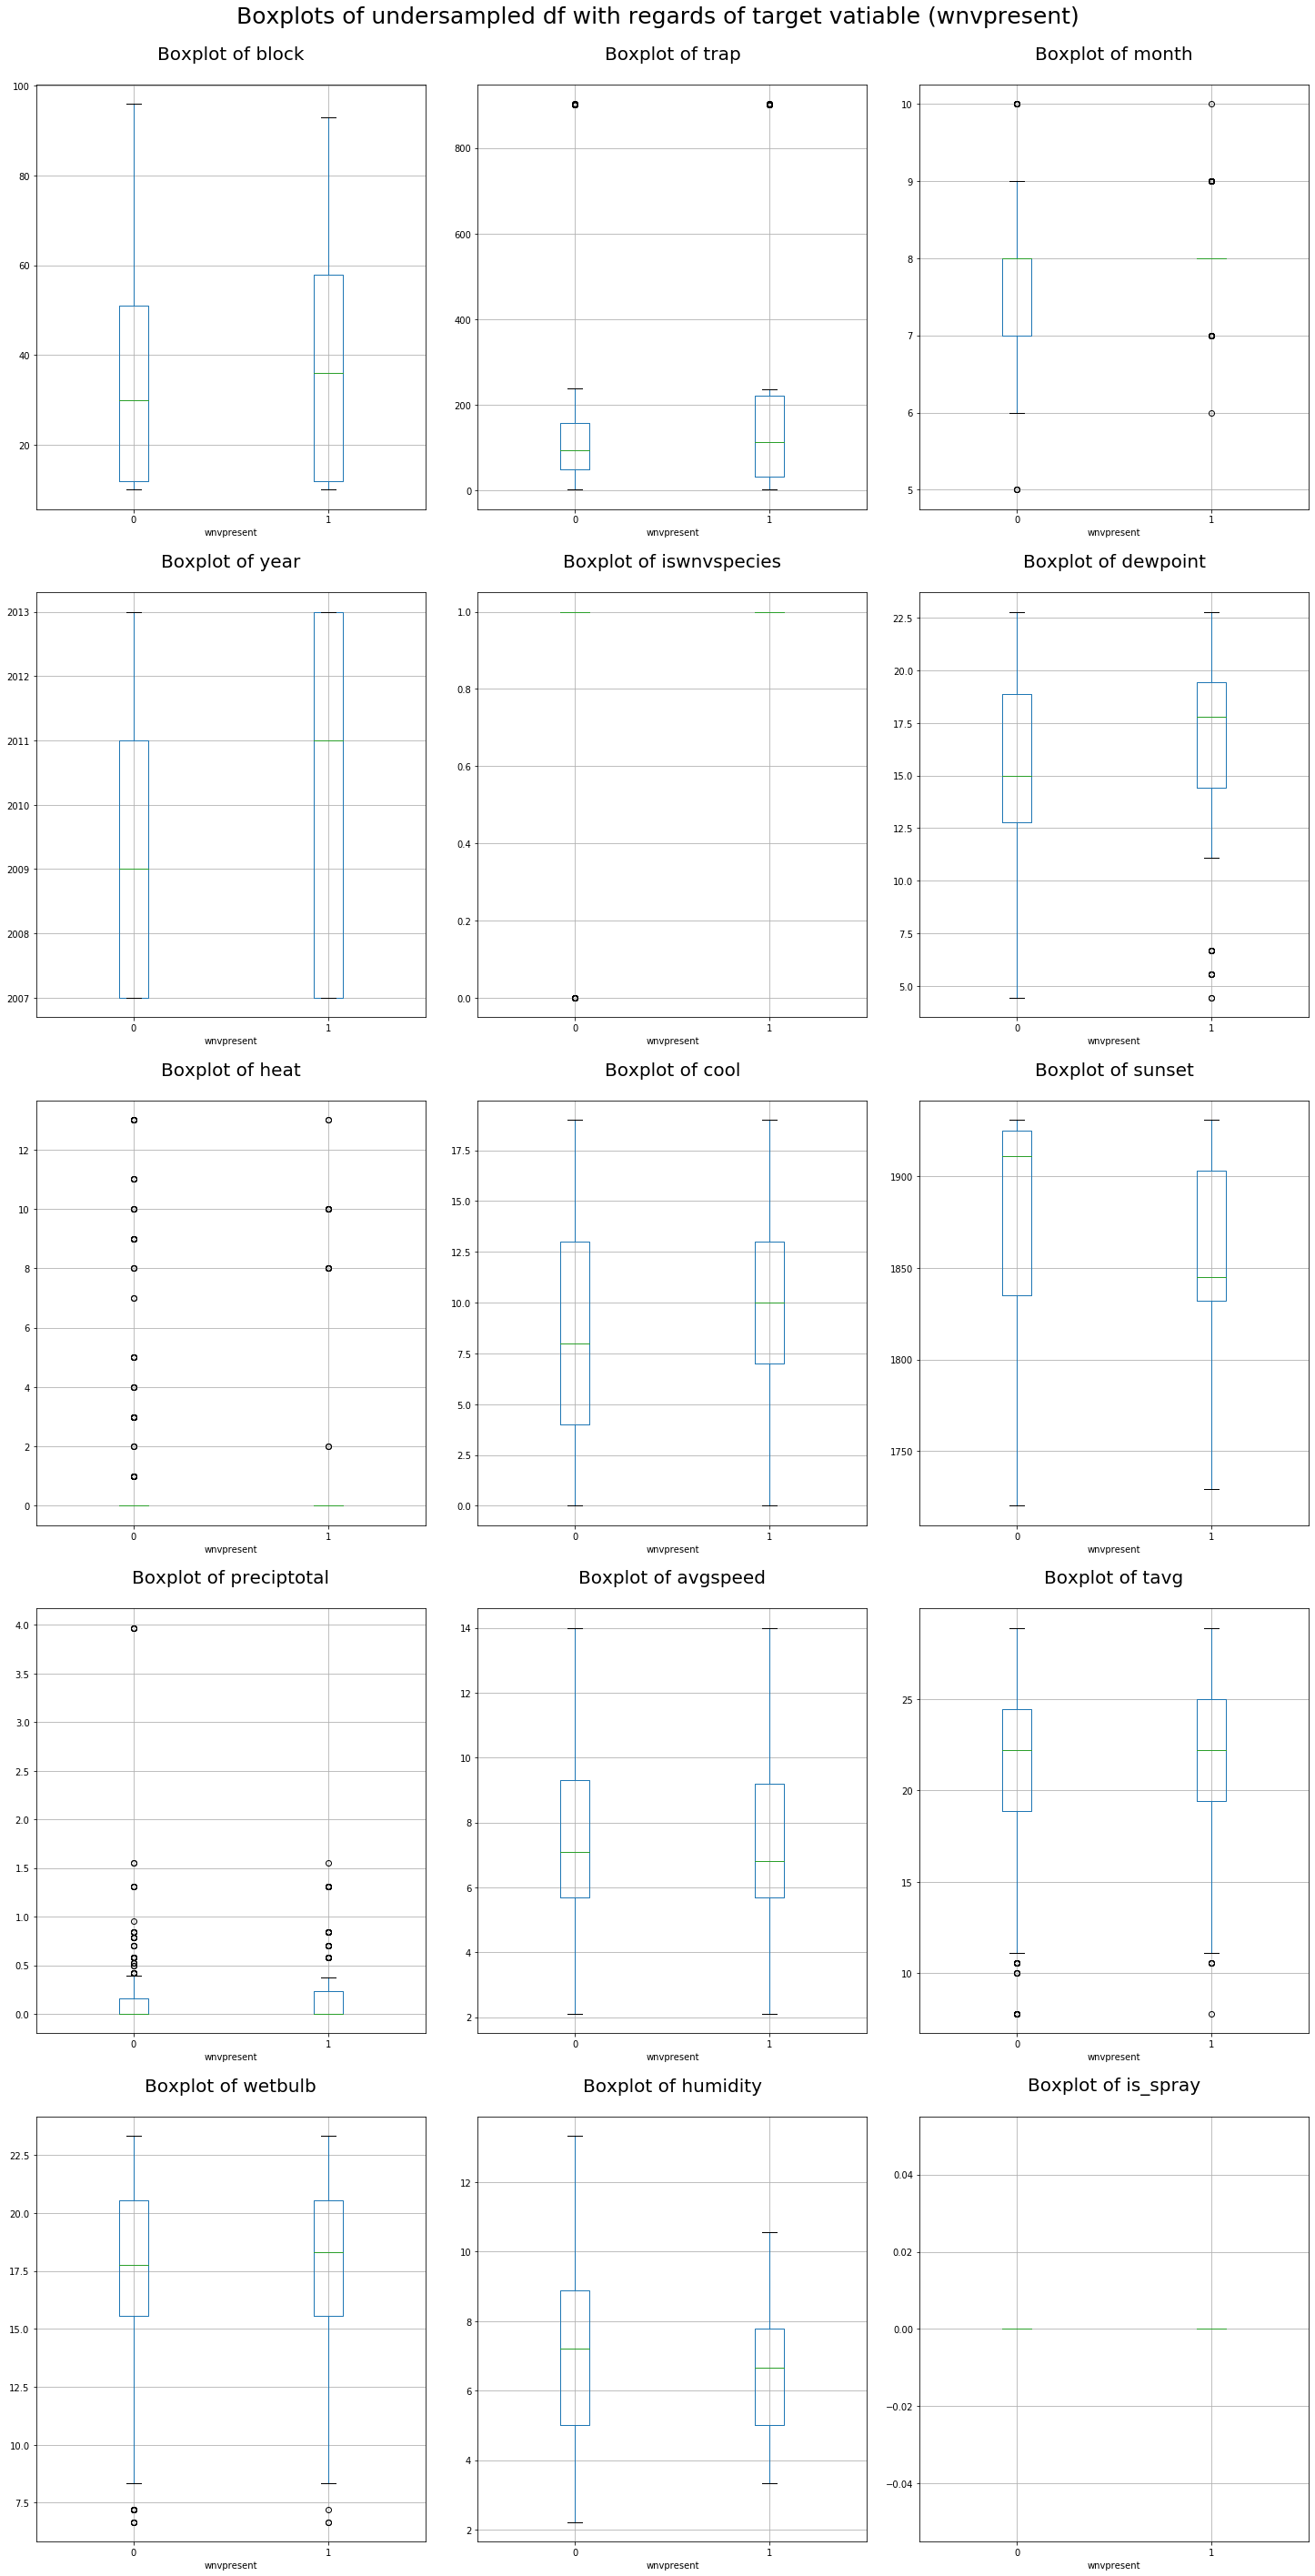

In [721]:
# boxplots of undersampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of undersampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(downsampled, X_unders.columns,maintitle,blocks=[10,12],figsize=(20,40))

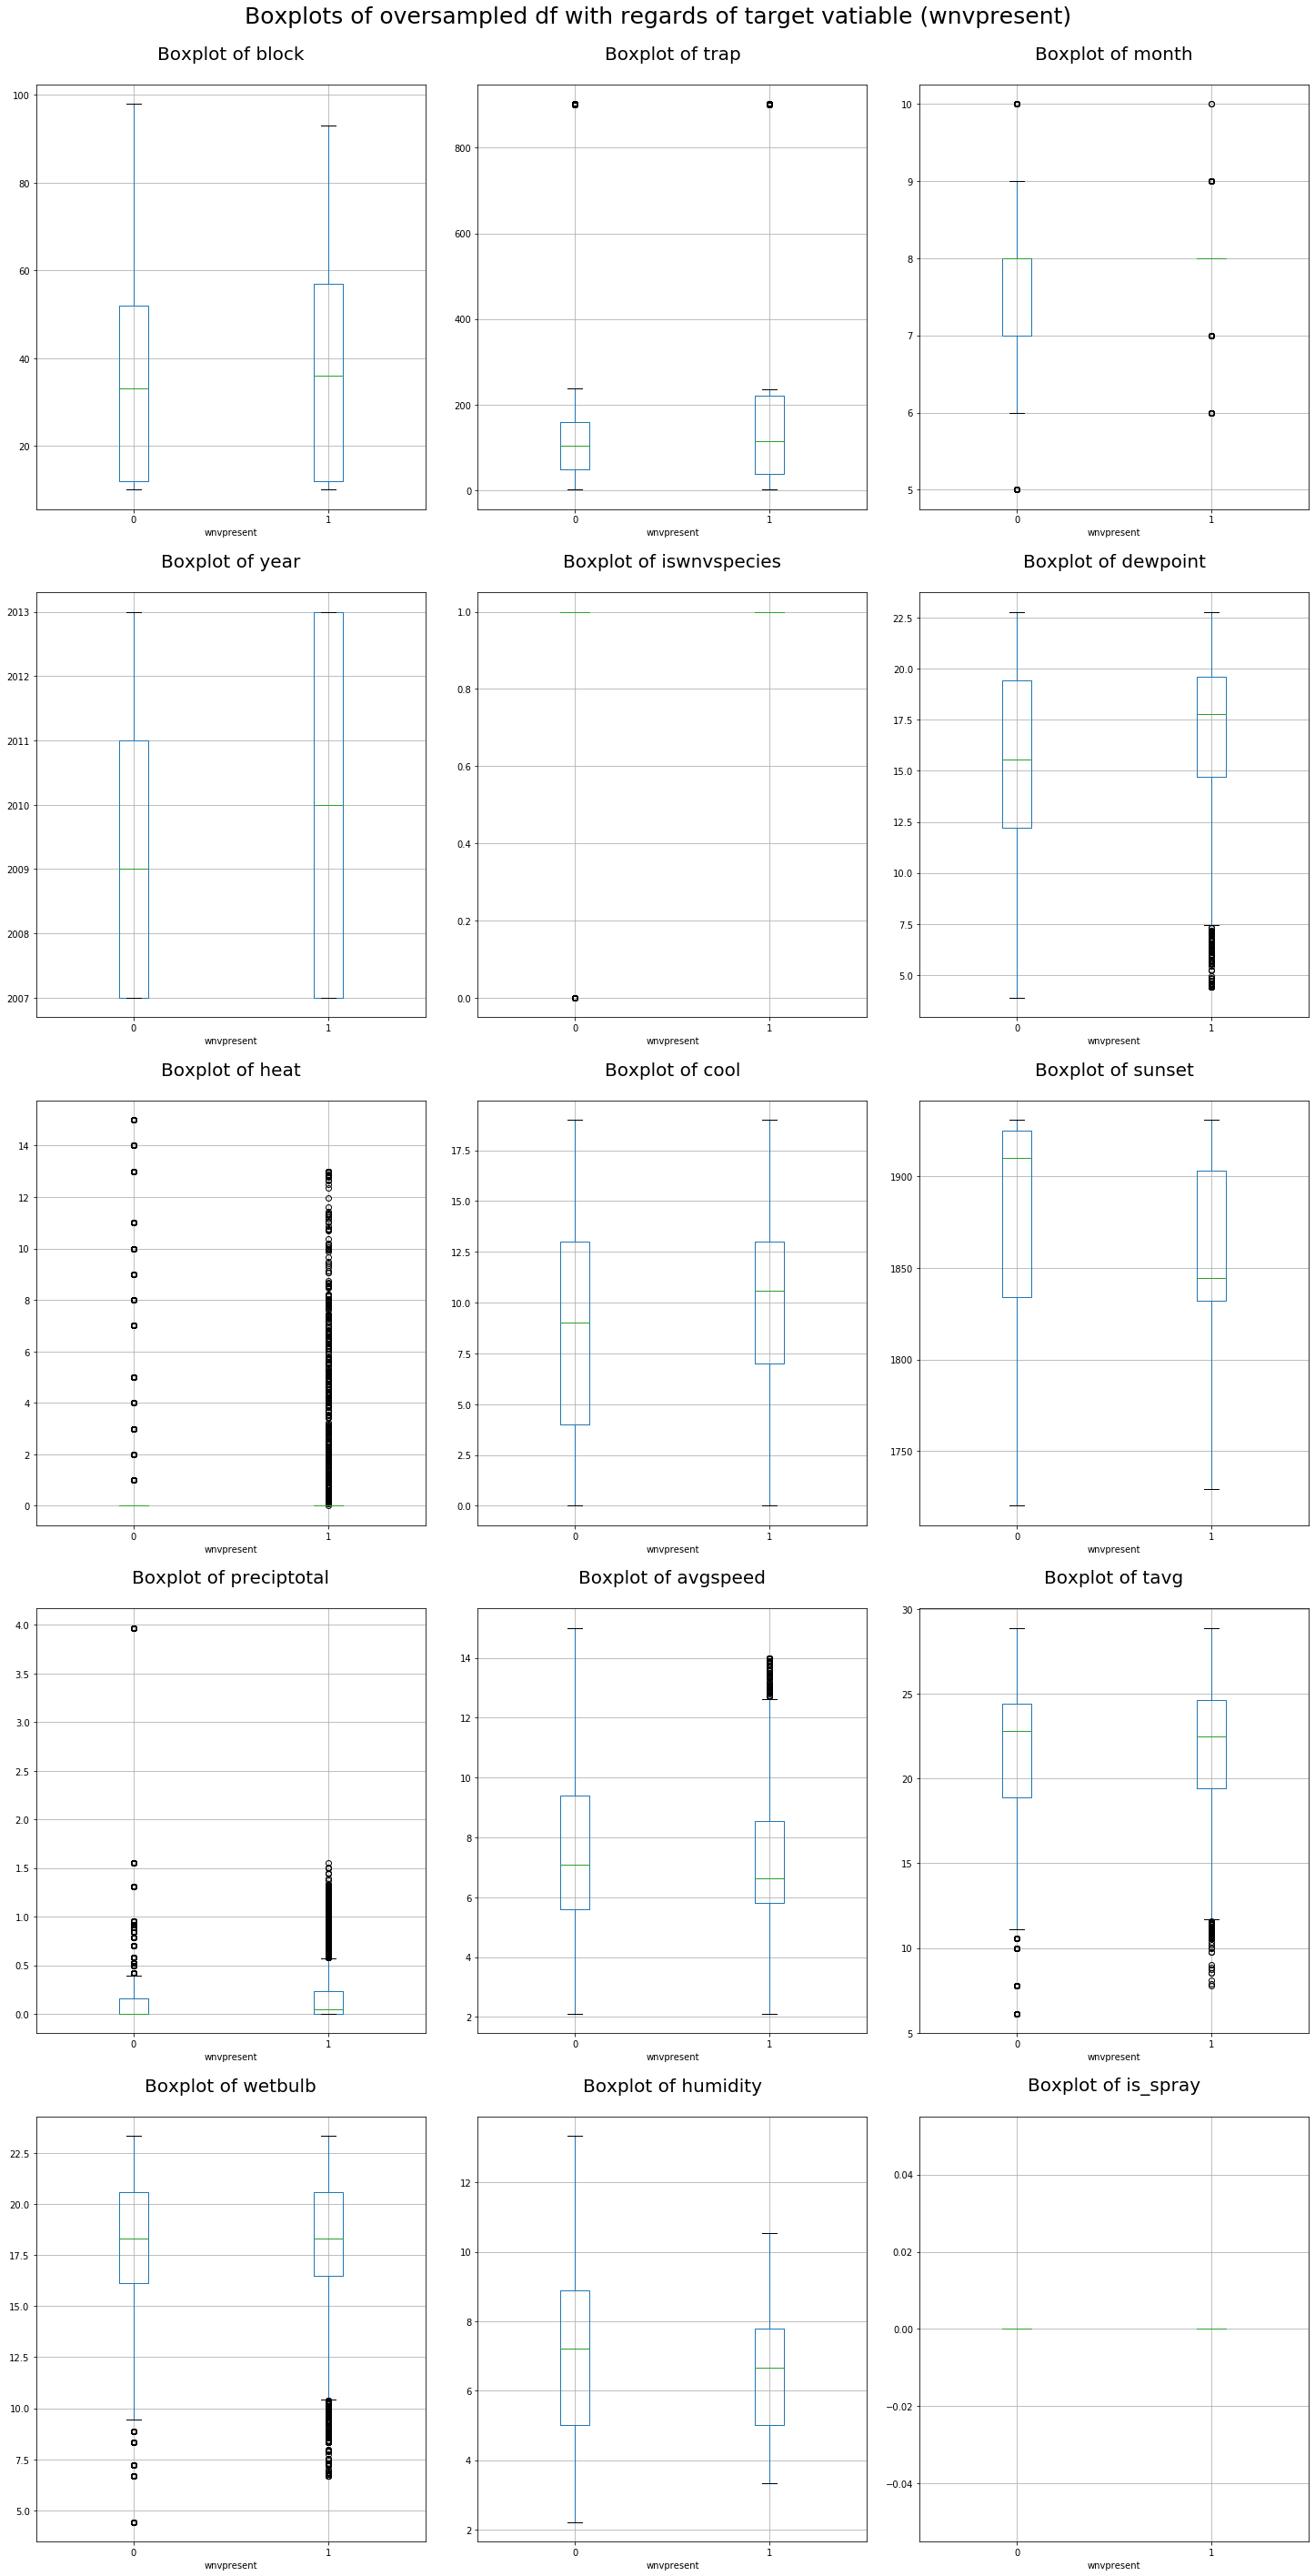

In [722]:
# boxplots of oversampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of oversampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(oversempling_smote, X_train_sm.columns,maintitle,blocks=[10,12],figsize=(20,40))

**Comment**

The difference between classes of the target variable (the presence of the virus) is not very distinct.

Next step is to check the performance of 5 models on the 3 new datasets with resampling.

In [723]:
# Creating function for simple models evaluation
def sample_evaluation(X,y,models,names_samples,X_test=X_test,y_test=y_test,on= True):
    if on:
        for i in range(len(X)):
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X[i])
            X_test_scaled = ss.transform(X_test)
            for model in models:
                cv_scores = cross_val_score(model,X_train_scaled,y[i])
                model.fit(X_train_scaled,y[i])
                train_score = model.score(X_train_scaled,y[i])
                test_score = model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                # set of predicted labels match the corresponding set of true labels
                y_predicted = model.predict(X_test_scaled)
                try:
                    pred_proba = [i[1] for i in model.predict_proba(X_test_scaled)]
                    pred_df = pd.DataFrame({'true_values': y_test,
                                'pred_probs':pred_proba})
                    print(f'ROC score {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}')
                except:
                    pass
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [724]:
# Change on to True to run a function
lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier()
sample_evaluation([X_unders, X_train_sm, X_smt],[y_unders, y_train_sm,y_smt],
                  models=[lr,knn,svm,dtree,randtree,],
                  names_samples=['undersampling','oversampling','over-undersampling'],
                 on= False)

undersampling
LogisticRegression
CV [0.69879518 0.73939394 0.68484848 0.6969697  0.6969697 ]
train 0.7215496368038741
test 0.6239055957365817
ROC score 0.758
True Negatives: 1528
False Positives: 961
False Negatives: 27
True Positives: 111
accuracy 0.624, precision 0.104,recall 0.804, f1 0.183
undersampling
KNeighborsClassifier
CV [0.74096386 0.73333333 0.70909091 0.69090909 0.66060606]
train 0.7929782082324455
test 0.6947087933003426
ROC score 0.758
True Negatives: 1726
False Positives: 763
False Negatives: 39
True Positives: 99
accuracy 0.695, precision 0.115,recall 0.717, f1 0.198
undersampling
SVC
CV [0.72891566 0.8        0.70909091 0.73333333 0.70909091]
train 0.7723970944309927
test 0.727826417967263
True Negatives: 1815
False Positives: 674
False Negatives: 41
True Positives: 97
accuracy 0.728, precision 0.126,recall 0.703, f1 0.213
undersampling
DecisionTreeClassifier
CV [0.71686747 0.67272727 0.68484848 0.65454545 0.63636364]
train 0.9491525423728814
test 0.6920441568328892
R

        undersampling
        LogisticRegression
        CV [0.6746988  0.70909091 0.76363636 0.75151515 0.66060606]
        train 0.7179176755447942
        test 0.6102017510468215
        ROC score 0.753
        True Negatives: 1494
        False Positives: 995
        False Negatives: 29
        True Positives: 109
        accuracy 0.61, precision 0.099,recall 0.79, f1 0.176
        ==================
        undersampling
        KNeighborsClassifier
        CV [0.69277108 0.72727273 0.73939394 0.78787879 0.6969697 ]
        train 0.8123486682808717
        test 0.7171678720974496
        ROC score 0.775
        True Negatives: 1784
        False Positives: 705
        False Negatives: 38
        True Positives: 100
        accuracy 0.717, precision 0.124,recall 0.725, f1 0.212
        ==================
        undersampling
        SVC
        CV [0.65662651 0.76363636 0.76363636 0.80606061 0.73333333]
        train 0.7857142857142857
        test 0.7023220403502094
        True Negatives: 1736
        False Positives: 753
        False Negatives: 29
        True Positives: 109
        accuracy 0.702, precision 0.126,recall 0.79, f1 0.218
        ==================
        undersampling
        DecisionTreeClassifier
        CV [0.69277108 0.66060606 0.73939394 0.73939394 0.67272727]
        train 0.9539951573849879
        test 0.652455272173582
        ROC score 0.684
        True Negatives: 1617
        False Positives: 872
        False Negatives: 41
        True Positives: 97
        accuracy 0.652, precision 0.1,recall 0.703, f1 0.175
        ==================
        undersampling
        RandomForestClassifier
        CV [0.71686747 0.6969697  0.75151515 0.78787879 0.69090909]
        train 0.9539951573849879
        test 0.6848115721355158
        ROC score 0.782
        True Negatives: 1701
        False Positives: 788
        False Negatives: 40
        True Positives: 98
        accuracy 0.685, precision 0.111,recall 0.71, f1 0.191
        ==================
        oversampling
        LogisticRegression
        CV [0.5542441  0.52787544 0.7187343  0.64314415 0.54746359]
        train 0.7052235057759919
        test 0.6406547392462886
        ROC score 0.755
        True Negatives: 1578
        False Positives: 911
        False Negatives: 33
        True Positives: 105
        accuracy 0.641, precision 0.103,recall 0.761, f1 0.182
        ==================
        oversampling
        KNeighborsClassifier
        CV [0.52712205 0.59643395 0.66951281 0.60396786 0.52561527]
        train 0.9235057759919638
        test 0.9113056718690522
        ROC score 0.911
        True Negatives: 2305
        False Positives: 184
        False Negatives: 49
        True Positives: 89
        accuracy 0.911, precision 0.326,recall 0.645, f1 0.433
        ==================
        oversampling
        SVC
        CV [0.56830738 0.60999498 0.68006027 0.61752888 0.54193872]
        train 0.8398292315419387
        test 0.7849257708412638
        True Negatives: 1956
        False Positives: 533
        False Negatives: 32
        True Positives: 106
        accuracy 0.785, precision 0.166,recall 0.768, f1 0.273
        ==================
        oversampling
        DecisionTreeClassifier
        CV [0.42717228 0.58186841 0.64113511 0.62255148 0.49221497]
        train 0.9600703164239076
        test 0.9337647506661592
        ROC score 0.961
        True Negatives: 2374
        False Positives: 115
        False Negatives: 59
        True Positives: 79
        accuracy 0.934, precision 0.407,recall 0.572, f1 0.476
        ==================
        oversampling
        RandomForestClassifier
        CV [0.51205424 0.59367152 0.6936213  0.61953792 0.49824209]
        train 0.9600703164239076
        test 0.9299581271412257
        ROC score 0.958
        True Negatives: 2357
        False Positives: 132
        False Negatives: 52
        True Positives: 86
        accuracy 0.93, precision 0.394,recall 0.623, f1 0.483
        ==================
        over-undersampling
        LogisticRegression
        CV [0.55292934 0.53356802 0.70850101 0.65719316 0.54225352]
        train 0.7017402675787144
        test 0.628854206318995
        ROC score 0.756
        True Negatives: 1546
        False Positives: 943
        False Negatives: 32
        True Positives: 106
        accuracy 0.629, precision 0.101,recall 0.768, f1 0.179
        ==================
        over-undersampling
        KNeighborsClassifier
        CV [0.5285391  0.57405079 0.65593561 0.60764588 0.53445674]
        train 0.9107232672769339
        test 0.9128283212790255
        ROC score 0.906
        True Negatives: 2315
        False Positives: 174
        False Negatives: 55
        True Positives: 83
        accuracy 0.913, precision 0.323,recall 0.601, f1 0.42
        ==================
        over-undersampling
        SVC
        CV [0.56877043 0.6097561  0.67756539 0.61594567 0.53722334]
        train 0.8409616738758676
        test 0.7807384849638371
        True Negatives: 1954
        False Positives: 535
        False Negatives: 41
        True Positives: 97
        accuracy 0.781, precision 0.153,recall 0.703, f1 0.252
        ==================
        over-undersampling
        DecisionTreeClassifier
        CV [0.42896656 0.55066633 0.68938632 0.57721328 0.49320926]
        train 0.9595111155819334
        test 0.9341454130186525
        ROC score 0.959
        True Negatives: 2379
        False Positives: 110
        False Negatives: 63
        True Positives: 75
        accuracy 0.934, precision 0.405,recall 0.543, f1 0.464
        ==================
        over-undersampling
        RandomForestClassifier
        CV [0.51294946 0.59994971 0.68158954 0.61770624 0.49823944]
        train 0.9595111155819334
        test 0.9333840883136658
        ROC score 0.956
        True Negatives: 2371
        False Positives: 118
        False Negatives: 57
        True Positives: 81
        accuracy 0.933, precision 0.407,recall 0.587, f1 0.481
        ==================

The models above illustrated that oversampling showing better results than undersampling or combination of over and undersampling. Preliminary, KNeighborsClassifier, DecisionTreeClassifier and RandomForestClassifier got better scores than LogisticRegression and SVC based on accuracy but LogisticRegression is a bit better performed in terms of recall.

Next step is tune hyperparameters of models with gridsearch.

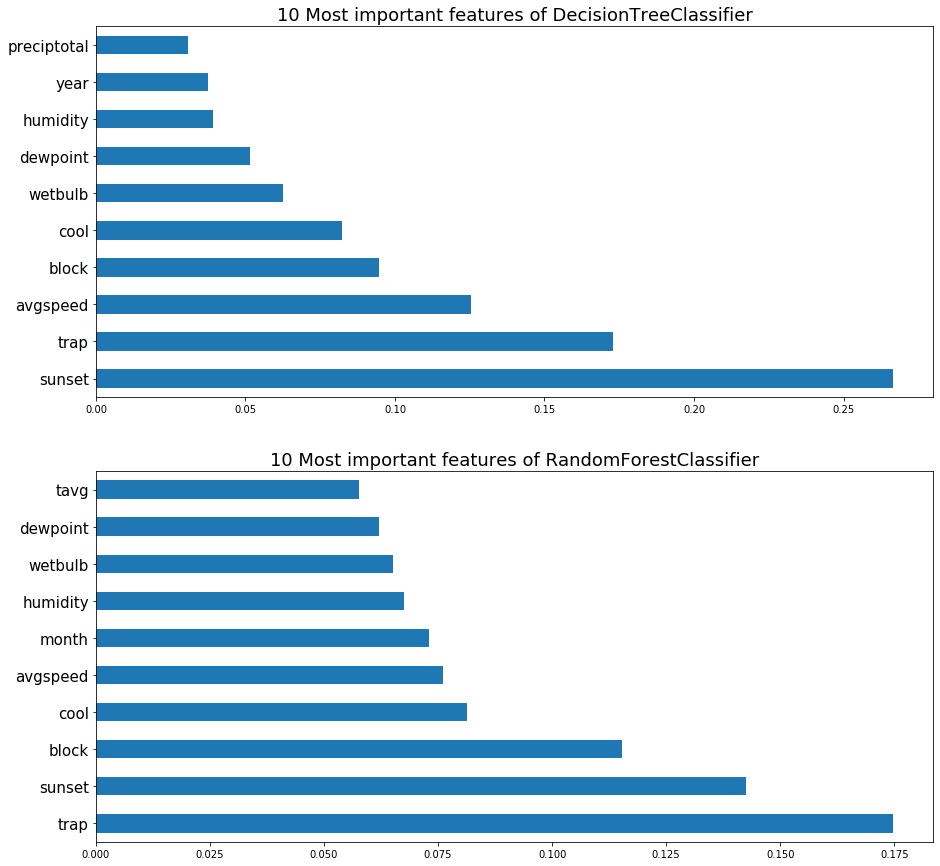

In [725]:
fig,ax = plt.subplots(2,1)
np.ravel(ax)
for i,model in enumerate([dtree,randtree]):
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances.nlargest(10).plot(kind='barh', figsize=(15,15),ax=ax[i])
    model_name = str(model).split('(')[0]
    ax[i].set_title(f'10 Most important features of {model_name}',fontsize=18)
    for tick in ax[i].yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

From the bar charts 10 most influential features can be seen, they can be classified on three categories: location (trap, block), time(sunset, month) and weather(cool, avgspeed, tavg ect).

In [726]:
# Creating function for models evaluation with gridsearch parameters
def sample_evaluation_grid(X,y,models,params,names_samples,X_test=X_test,y_test=y_test,on=True):
    """
    Use different resample and different ML models to evaluate perfomance with gridsearch
    Takes:
    X - list of resampled X
    y - list of resampled y
    params - list of hyperparameters for gridsearch
    name_samples - list of str - name of resampling technique
    
    Prints accoracy score on train and test data
    """
    if on:
        for i in range(len(X)):
            X_train = X[i]
            y_train = y[i]
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X_train)
            X_test_scaled = ss.transform(X_test)
            for j, model in enumerate(models):
                grid = GridSearchCV(model,param_grid=params[j])
                cv_scores = cross_val_score(grid,X_train_scaled,y_train)
                grid.fit(X_train_scaled,y_train)
                best_model = grid.best_estimator_
                best_model.fit(X_train_scaled,y_train)
                train_score = best_model.score(X_train_scaled,y_train)
                test_score = best_model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print(grid.best_params_)
                y_predicted = best_model.predict(X_test_scaled)
                try:
                    pred_proba = [i[1] for i in best_model.predict_proba(X_test_scaled)]
                    pred_df = pd.DataFrame({'true_values': y_test,
                                'pred_probs':pred_proba})
                    print(f'ROC score {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}')
                except:
                    pass
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                # set of predicted labels match the corresponding set of true labels
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [727]:
# Based on the above the oversampling method was chosen
# Creating an oversample df using a function written above
on= False
if on:
    X,y = resampling_dataset('over',X,y,on=True)


# Using function for models evaluation with gridsearch
lr = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier(n_jobs=-1)

# Change on to True to run a function
sample_evaluation_grid([X],[y],
models=[lr,knn,svm,dtree,randtree,],names_samples=['oversampling'],
params = [{'penalty':['l2','none'],'tol':[0.0001,0.001],'max_iter':[500,700]},
         {'n_neighbors':[3,5,7], 'weights':['uniform','distance']},
         {'degree':[1,3,6], 'C':[0.1,0.3,1]},
        {'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]},
        {'n_estimators':[80,100,120],'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]}],
                       on= False)

oversampling
LogisticRegression
{'max_iter': 500, 'penalty': 'l2', 'tol': 0.0001}
ROC score 0.758
CV [0.55600201 0.53239578 0.65770969 0.61727775 0.54043194]
train 0.7015067805123054
test 0.6273315569090216
True Negatives: 1542
False Positives: 947
False Negatives: 32
True Positives: 106
accuracy 0.627, precision 0.101,recall 0.768, f1 0.178
oversampling
KNeighborsClassifier
{'n_neighbors': 3, 'weights': 'distance'}
ROC score 0.902
CV [0.51607233 0.59894525 0.65796082 0.61074837 0.52963335]
train 0.943345052737318
test 0.9390940236010659
True Negatives: 2397
False Positives: 92
False Negatives: 68
True Positives: 70
accuracy 0.939, precision 0.432,recall 0.507, f1 0.467
oversampling
SVC
{'C': 1, 'degree': 1}
CV [0.56102461 0.57157207 0.68809643 0.60220994 0.52536414]
train 0.8409342039176293
test 0.7887323943661971
True Negatives: 1968
False Positives: 521
False Negatives: 34
True Positives: 104
accuracy 0.789, precision 0.166,recall 0.754, f1 0.273
oversampling
DecisionTreeClassifier


        oversampling
        LogisticRegression
        {'max_iter': 500, 'penalty': 'l2', 'tol': 0.0001}
        ROC score 0.755
        CV [0.69482152 0.71920563 0.70588235 0.68845864 0.7085743 ]
        train 0.7057019308125503
        test 0.6414160639512753
        True Negatives: 1580
        False Positives: 909
        False Negatives: 33
        True Positives: 105
        accuracy 0.641, precision 0.104,recall 0.761, f1 0.182
        ==================
        oversampling
        KNeighborsClassifier
        {'n_neighbors': 7, 'weights': 'distance'}
        ROC score 0.914
        CV [0.83760684 0.89844143 0.90447461 0.90243902 0.89841589]
        train 0.9195997586484312
        test 0.9531785306433194
        True Negatives: 2441
        False Positives: 48
        False Negatives: 75
        True Positives: 63
        accuracy 0.953, precision 0.568,recall 0.457, f1 0.506
        ==================
        oversampling
        SVC
        {'C': 1, 'degree': 1}
        CV [0.81950729 0.84565108 0.83836099 0.83153131 0.82977118]
        train 0.8401548672566371
        test 0.7849257708412638
        True Negatives: 1956
        False Positives: 533
        False Negatives: 32
        True Positives: 106
        accuracy 0.785, precision 0.166,recall 0.768, f1 0.273
        ==================
        oversampling
        DecisionTreeClassifier
        {'max_depth': None, 'min_samples_leaf': 1}
        ROC score 0.959
        CV [0.88989442 0.94343891 0.94720965 0.94870505 0.94996228]
        train 0.9600261464199518
        test 0.9322421012561858
        True Negatives: 2370
        False Positives: 119
        False Negatives: 59
        True Positives: 79
        accuracy 0.932, precision 0.399,recall 0.572, f1 0.47
        ==================
        oversampling
        RandomForestClassifier
        {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 80}
        ROC score 0.957
        CV [0.8959276  0.9479638  0.95274007 0.9517224  0.95473975]
        train 0.9599255832662912
        test 0.9333840883136658
        True Negatives: 2367
        False Positives: 122
        False Negatives: 53
        True Positives: 85
        accuracy 0.933, precision 0.411,recall 0.616, f1 0.493
        ==================
        
 From the scores above, RandomForestClassifier, DecisionTreeClassifier and KNeighborsClassifier showed better results. The best hyperparameters will be applied for more complicated models.

In [728]:
# Evaluation of ensembles of models
on = False
if on:
    X,y = resampling_dataset('over',X,y,on= True)

    gradb = GradientBoostingClassifier()
    bag = BaggingClassifier()
    ada = AdaBoostClassifier(RandomForestClassifier(max_depth=None,min_samples_leaf=1))

    sample_evaluation([X],[y],
    models=[gradb],names_samples=['oversampling'],on=True)
    sample_evaluation_grid([X],[y],
    models=[bag,ada],names_samples=['oversampling'],params = [
             {'base_estimator':[KNeighborsClassifier(n_jobs=-1,n_neighbors=7,weights='distance'),
                                RandomForestClassifier(max_depth=None,min_samples_leaf=1)]},
             {'base_estimator':[DecisionTreeClassifier(),
                                RandomForestClassifier(max_depth=None,min_samples_leaf=1)]}
             ],on= True)

oversampling
GradientBoostingClassifier
CV [0.49070819 0.56529382 0.7420894  0.64213963 0.46936213]
train 0.8678051230537418
test 0.8108108108108109
ROC score 0.862
True Negatives: 2034
False Positives: 455
False Negatives: 42
True Positives: 96
accuracy 0.811, precision 0.174,recall 0.696, f1 0.279
oversampling
BaggingClassifier
{'base_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='distance')}
ROC score 0.956
CV [0.53164239 0.60497238 0.68081366 0.63360121 0.54294324]
train 0.9586639879457559
test 0.9345260753711458
True Negatives: 2366
False Positives: 123
False Negatives: 49
True Positives: 89
accuracy 0.935, precision 0.42,recall 0.645, f1 0.509
oversampling
AdaBoostClassifier
{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=Non

        oversampling
        GradientBoostingClassifier
        CV [0.84062343 0.8670186  0.87405732 0.86698516 0.85994468]
        train 0.8637369267900241
        test 0.8153787590407309
        True Negatives: 2049
        False Positives: 440
        False Negatives: 45
        True Positives: 93
        accuracy 0.815, precision 0.174,recall 0.674, f1 0.277
        ==================
        oversampling
        BaggingClassifier
        {'base_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=None, max_features='auto',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=None, oob_score=False, random_state=None,
                               verbose=0, warm_start=False)}
        CV [0.89768728 0.94746104 0.94997486 0.95096807 0.9522253 ]
        train 0.9572103781174578
        test 0.9261515036162924
        True Negatives: 2348
        False Positives: 141
        False Negatives: 53
        True Positives: 85
        accuracy 0.926, precision 0.376,recall 0.616, f1 0.467
        ==================
        oversampling
        AdaBoostClassifier
        {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, 
        class_weight=None, criterion='gini',
                               max_depth=None, max_features=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, presort='deprecated',
                               random_state=None, splitter='best')}
        ROC score 0.961
        CV [0.53365143 0.59392265 0.62556504 0.62631843 0.54696133]
        train 0.9600703164239076
        test 0.9322421012561858
        True Negatives: 2361
        False Positives: 128
        False Negatives: 50
        True Positives: 88
        accuracy 0.932, precision 0.407,recall 0.638, f1 0.497
        ==================

#### Based on the models' perfomance above, Voting classifier will be built.

In [729]:
# Evaluation of ensambles of models
X,y = resampling_dataset('over',X,y,on= True)

# Creation a voting classifier with best models
vc = VotingClassifier(estimators=[('knn',KNeighborsClassifier(weights='distance')),
                                  ('ada',AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
                                  ('bagg',BaggingClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2))),
                                  ('rfor',RandomForestClassifier()),('grad',GradientBoostingClassifier())
                                 ],voting='soft')
# Using gridsearch for better evaluation
on= False
if on:
    X_train = X
    y_train = y
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    vc.fit(X_train_scaled,y_train)
    print(vc.score(X_train_scaled,y_train))
    print(vc.score(X_test_scaled,y_test))
    # Evaluation
    # set of predicted labels match the corresponding set of true labels
    y_predicted = vc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_predicted)
    # ratio tp / (tp + fp)
    precision = precision_score(y_test, y_predicted)             
    # ratio tp / (tp + fn)
    recall = recall_score(y_test, y_predicted)
    # weighted average of the precision and recall
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_predicted)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')

0.9561526870919136
0.9379520365435858
True Negatives: 2380
False Positives: 109
False Negatives: 54
True Positives: 84
accuracy 0.938, precision 0.435,recall 0.609, f1 0.508


        0.9571600965406275
        0.9421393224210126
        True Negatives: 2395
        False Positives: 94
        False Negatives: 58
        True Positives: 80
        accuracy 0.942, precision 0.46,recall 0.58, f1 0.513

In [730]:
# Creating Receiver Operating Characteristic (ROC) Curve
def roc_curve(pred_proba,y_test=y_test):
    
    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Recall', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [731]:
# Creating distribution of divided probability
def div_prob(pred_proba,y_test=y_test):

    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))
    # Create two histograms of observations.
    plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
             bins=25,
             color='#65a8a7',
             alpha = 0.5,
             label='WNVirus not present')
    plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
             bins=25,
             color='#fcba03',
             alpha = 0.5,
             label='WNVirus present')

    # Add vertical line at P(Outcome = 1) = 0.5.
    plt.vlines(x=0.5,
               ymin = 0,
               ymax = 65,
               color='r',
               linestyle = '--')

    # Label axes.
    plt.title('Distribution of Probability', fontsize=22)
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
    plt.text(y = 40,x = 0.1,s = 'True negative',color='blue')
    plt.text(y = 10,x = 0.25,s = 'False negative',color='orange')
    plt.text(y = 10,x = 0.55,s = 'False positive',color='blue')
    plt.text(y = 40,x = 0.75,s = 'True positive',color='orange')
    # Create legend.
    plt.legend(fontsize=20,loc='upper center');

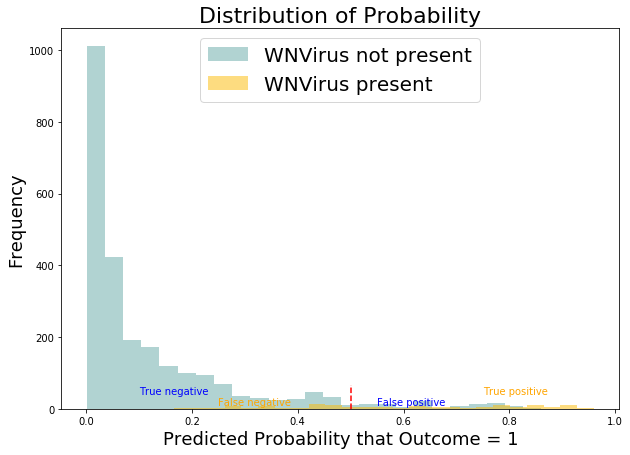

In [732]:
# Evaluation VotingClassifier
pred_proba = [i[1] for i in vc.predict_proba(X_test_scaled)]
div_prob(pred_proba)

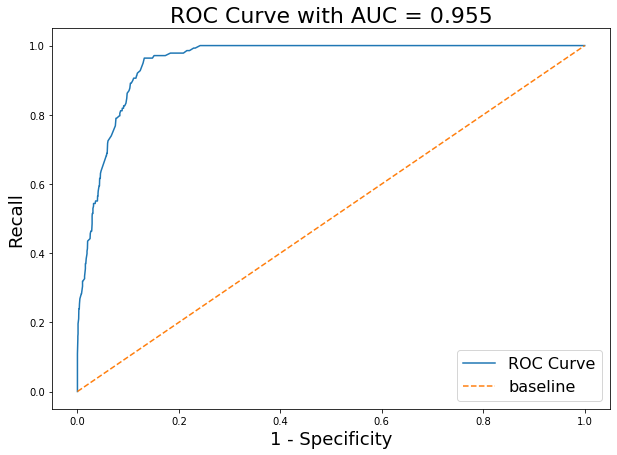

In [733]:
roc_curve(pred_proba)

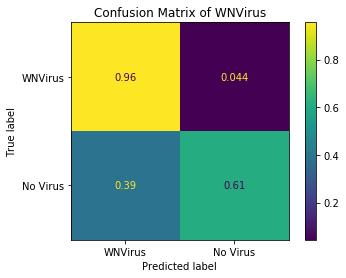

In [734]:
disp = plot_confusion_matrix(vc,X_test_scaled,y_test,normalize='true',
                             display_labels=['WNVirus','No Virus'])
disp.ax_.set_title('Confusion Matrix of WNVirus');

In [735]:
# Fitting model with full data for test prediction
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X)
X_test_subm_scaled = ss.transform(X_test_submit)

vc.fit(X_train_scaled,y)

submit_df = pd.DataFrame()
submit_df['id'] = main_df_test_c['id']
submit_df['wnvpresent'] = vc.predict(X_test_subm_scaled)
submit_df.to_csv('../datasets/submission_c1.csv', index=False)

#### Kaggle submission scores

|Private Score|Public Score|
|--|--|
|0.65931|0.65337|

From the scores, we can conclude that our model generalizability is not so well.

Let's look at misclassification. It is important to lower false negative predictions.

In [736]:
# looking for false negative predictions
pred_proba = vc.predict_proba(X_test_scaled)
pred = vc.predict(X_test_scaled)
pred_df = pd.DataFrame({'true_values': y_test,
                        'predict':pred,
                        'pred_probs':list(pred_proba)})

wrong_predictions=pred_df[(pred_df['true_values']-pred_df['predict'])==1]
wrong_predictions
# To see features of misclassified datapoints
# X_test.loc[wrong_predictions.index,:]

,true_values,predict,pred_probs
1309,1,0,"[0.5320787289394153, 0.4679212710605847]"
2969,1,0,"[0.5187286463821502, 0.4812713536178498]"
10484,1,0,"[0.7490615844188918, 0.25093841558110813]"
8959,1,0,"[0.5973681325268311, 0.4026318674731689]"
7919,1,0,"[0.8166190884522964, 0.18338091154770353]"
2915,1,0,"[0.5421217521529588, 0.45787824784704123]"
7592,1,0,"[0.6436796952183248, 0.3563203047816751]"
9400,1,0,"[0.5627474719270664, 0.43725252807293363]"
9664,1,0,"[0.5267336830832494, 0.4732663169167507]"
8905,1,0,"[0.549963470450318, 0.45003652954968204]"


Most of false negative probabilities are close to threshold of 0.5.
Let's use threshold of 0.6

In [737]:
right_predictions=pred_df[(pred_df['true_values']==1) & (pred_df['predict']==1)]
right_predictions['pred_probs'].mean()

array([0.23869217, 0.76130783])

Mean of the probability of correct predictions is 0.89 for positive class.

In [738]:
# Creating a table with test prediction and probabilities
X_test_subm_scaled = ss.transform(X_test_submit)
pred_proba = vc.predict_proba(X_test_subm_scaled)
pred = vc.predict(X_test_subm_scaled)
submit_df = pd.DataFrame({'id': main_df_test['id'],
                        'wnvpresent':pred,
                        'pred_probs':list(pred_proba)})

submit_df

,id,wnvpresent,pred_probs
0,1,0,"[0.8964364765060946, 0.10356352349390532]"
1,2,0,"[0.8964364765060946, 0.10356352349390532]"
2,3,0,"[0.8964364765060946, 0.10356352349390532]"
3,4,0,"[0.905711063764247, 0.09428893623575299]"
4,5,0,"[0.905711063764247, 0.09428893623575299]"
...,...,...,...
116288,116289,0,"[0.717589589372887, 0.282410410627113]"
116289,116290,0,"[0.717589589372887, 0.282410410627113]"
116290,116291,0,"[0.717589589372887, 0.282410410627113]"
116291,116292,0,"[0.717589589372887, 0.282410410627113]"


In [739]:
# Probability of classes are not very vary from the threashold == 0.5
submit_df[submit_df['wnvpresent']==0].mean()

id                                              57244.5
wnvpresent                                            0
pred_probs    [0.7396676564407341, 0.26033234355926327]
dtype: object

In [740]:
# Sifting probability threashold for positive class to 0.6
submit_df['0'] = submit_df['pred_probs'].map(lambda x: x[0])
submit_df['1'] = submit_df['pred_probs'].map(lambda x: x[1])
change_predict = submit_df[(submit_df['wnvpresent']==0) & 
                    (submit_df['0']<0.6) & (submit_df['1']<0.5)]
submit_df.loc[change_predict.index,'wnvpresent']=1
submit_df.head(3)

,id,wnvpresent,pred_probs,0,1
0,1,0,"[0.8964364765060946, 0.10356352349390532]",0.896436,0.103564
1,2,0,"[0.8964364765060946, 0.10356352349390532]",0.896436,0.103564
2,3,0,"[0.8964364765060946, 0.10356352349390532]",0.896436,0.103564


In [741]:
submit_df.drop(columns=['pred_probs','0','1'],inplace=True)
submit_df.to_csv('../datasets/submission_c2.csv', index=False)

|Private Score|Public Score|
|--|--|
|0.63812|0.63140|

The sifting of the threshold dropped Public and Private scores.

### Approach D

In [98]:
# Make copy of main dataframe
main_df_D = main_df.copy()
main_df_test_D = main_df_test.copy()

In [99]:
# Check for any additional columns between train and test
main_df_D.columns.difference(main_df_test_D.columns)

Index(['nummosquitos', 'wnvpresent'], dtype='object')

In [100]:
# Check datasets type and shape
print(main_df_D.info())
print()
print(main_df_test_D.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
 12  day                     10506 non-null  int64 

In [101]:
# Drop address, addressnumberandStreet and date columns since they are dupes
main_df_D.drop(['address','addressnumberandstreet', 'date'], axis = 1, inplace= True)
main_df_test_D.drop(['address','addressnumberandstreet', 'date'], axis = 1, inplace= True)
# Drop snowfall and depth columns as they are missing data for the whole columns
main_df_D.drop(['depth','snowfall'], axis = 1, inplace= True)
main_df_test_D.drop(['depth','snowfall'], axis = 1, inplace= True)
# Drop is_spray columns as they have high number of missing data for the whole columns
# Drop codesum it does not match to the features provided on pdf
# Drop num of mosquitos to match test set
main_df_D.drop(['codesum', 'nummosquitos', 'is_spray'], axis = 1, inplace= True)
main_df_test_D.drop(['codesum','is_spray'], axis = 1, inplace= True)

In [102]:
# Check the correlation between target variable wnvpresent and the features 
main_df_D_num = main_df_D._get_numeric_data()
wnv_matrix = np.abs(main_df_D_num.corr())
print(wnv_matrix['wnvpresent'].sort_values(ascending=False))

wnvpresent         1.000000
sunrise            0.105227
month              0.100143
dewpoint           0.090427
tmin               0.072734
sunset             0.068451
longitude          0.060345
cool               0.058953
heat               0.056813
depart             0.055398
humidity           0.052233
resultspeed        0.051177
year               0.050865
tmax               0.050595
iswnvspecies       0.041362
wetbulb            0.030949
avgspeed           0.029958
latitude           0.028697
preciptotal        0.020917
tavg               0.018231
day                0.008245
addressaccuracy    0.008064
resultdir          0.007922
stnpressure        0.007428
sealevel           0.005620
block              0.004877
station                 NaN
Name: wnvpresent, dtype: float64


In [103]:
# Check the correlation matrix across the dataset, drop features that are highly correlated
corr_mat = main_df_D_num.corr().abs()
wnv_set = corr_mat.unstack()
wnv_set.sort_values(ascending = False).drop_duplicates().head(25)

wetbulb   wetbulb        1.000000
sealevel  stnpressure    0.992241
sunset    sunrise        0.959900
wetbulb   tavg           0.954852
avgspeed  resultspeed    0.903030
cool      tmin           0.894385
dewpoint  tmin           0.894094
month     sunrise        0.887902
tmax      cool           0.870348
sunset    month          0.852579
cool      dewpoint       0.834473
depart    tmax           0.813718
cool      depart         0.798282
tmin      tmax           0.748727
heat      tmax           0.747677
tmax      dewpoint       0.737809
depart    dewpoint       0.716375
latitude  longitude      0.701795
depart    tmin           0.694210
heat      tmin           0.669120
dewpoint  heat           0.624800
tavg      sunset         0.558609
sunset    wetbulb        0.546422
depart    heat           0.544174
tmin      wetbulb        0.528661
dtype: float64

In [104]:
# Drop sealevel, sunset, avgspeed and cool columns due to high collinearity
main_df_D.drop(['sealevel','sunset', 'avgspeed', 'cool'], axis = 1, inplace= True)
main_df_test_D.drop(['sealevel','sunset', 'avgspeed', 'cool'], axis = 1, inplace= True)
# Drop Station column as its redundant cause we know its from station 1
main_df_D.drop(['station'], axis = 1, inplace= True)
main_df_test_D.drop(['station'], axis = 1, inplace= True)

In [105]:
# Remove id columns for now
main_df_test_D.drop(['id'], axis = 1, inplace= True)

In [106]:
# Convert trap column to integer by removing the alphabets
def str_to_int(x):
    x = re.sub("[a-zA-Z]", "", x)
    return int(x)
main_df_D['trap'] = main_df_D['trap'].map(lambda x: str_to_int(x))
main_df_test_D['trap'] = main_df_test_D['trap'].map(lambda x: str_to_int(x))

In [107]:
# Get dummies for categorical columns species and street
main_df_D2 = pd.get_dummies(main_df_D, columns = ["street","species"])
main_df_test_D2 = pd.get_dummies(main_df_test_D, columns = ["street","species"])

In [108]:
# Remove columns in test set that are not in train
diff_columns = list(main_df_test_D2.columns.difference(main_df_D2.columns))
main_df_test_D2.drop(diff_columns, axis =1, inplace = True)

In [109]:
# Check Data shape
main_df_D2.shape

(10506, 158)

In [110]:
main_df_test_D2.shape

(116293, 157)

#### Create the Train and Test Split Data

In [111]:
# Input predictor variable
y = main_df_D2['wnvpresent']
X = main_df_D2.loc[:, main_df_D2.columns != 'wnvpresent']

In [112]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42)

In [113]:
# Dimension of X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8404, 157)
(8404,)
(2102, 157)
(2102,)


In [114]:
# View Majority and Minority class of WnvPresent
y_train.value_counts()

0    7963
1     441
Name: wnvpresent, dtype: int64

#### Feature Scaling

In [115]:
# Standardizing the features by using Standard Scaler to fit and transform X_train, transform X_test
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [116]:
# Increasing the ratio of imbalance dataset
smk = SMOTETomek(sampling_strategy=0.5)
X_train_sm, y_train_sm = smk.fit_sample(X_train, y_train)

#### Modeling - Decision Tree

In [117]:
#Set up pipeline with Decision Tree
pipe_dtree = Pipeline([
    ('dtree', DecisionTreeClassifier())
])
# Search over the following values of hyperparameters:
params_dtree = {
    'dtree__max_depth': [5, 7],
    'dtree__min_samples_split': [12, 14],
    'dtree__min_samples_leaf': [3, 4],
}
# Instantiate GridSearchCV
grid_dtree = GridSearchCV(pipe_dtree, param_grid=params_dtree, cv=10, verbose=1)
# Fit GridSearch to training data.
grid_dtree.fit(X_train_sm, y_train_sm)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   10.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dtree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                      

In [118]:
# Best Score, Parameter and Model Using GridSearch
print(f"Best Score: {round(grid_dtree.best_score_, 4)}")
print(f"Best Model: {round(grid_dtree.best_estimator_.score(X_test, y_test,),4)}")
print(f"Best Parameter: {grid_dtree.best_params_}")

Best Score: 0.85
Best Model: 0.8435
Best Parameter: {'dtree__max_depth': 7, 'dtree__min_samples_leaf': 4, 'dtree__min_samples_split': 14}


In [119]:
# Predicting the train and test data
dtree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=3,min_samples_split=14)
dtree.fit(X_train_sm, y_train_sm)
print(f"Train Score: {round(dtree.score(X_train_sm, y_train_sm), 4)}")
print(f"Test Score: {round(dtree.score(X_test, y_test), 4)}")

Train Score: 0.8567
Test Score: 0.8435


In [120]:
# Generate classification report
y_predict = dtree.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1992
           1       0.14      0.38      0.20       110

    accuracy                           0.84      2102
   macro avg       0.55      0.63      0.56      2102
weighted avg       0.92      0.84      0.88      2102



In [121]:
# Generate a confusion matrix
# Assign to TN,FP,FN and TP
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1731
False Positives: 261
False Negatives: 68
True Positives: 42


In [122]:
Accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Model Accuracy: {(Accuracy)}")
Sensitivity = tp / (tp + fn)
print(f"Model Sensitivity: {Sensitivity}")
Specificity = tn / (tn + fp)
print(f"Model Specificity: {Specificity}")
Precision = tp / (tp + fp)
print(f"Model Precision: {Precision}")

Model Accuracy: 0.8434823977164605
Model Sensitivity: 0.38181818181818183
Model Specificity: 0.8689759036144579
Model Precision: 0.13861386138613863


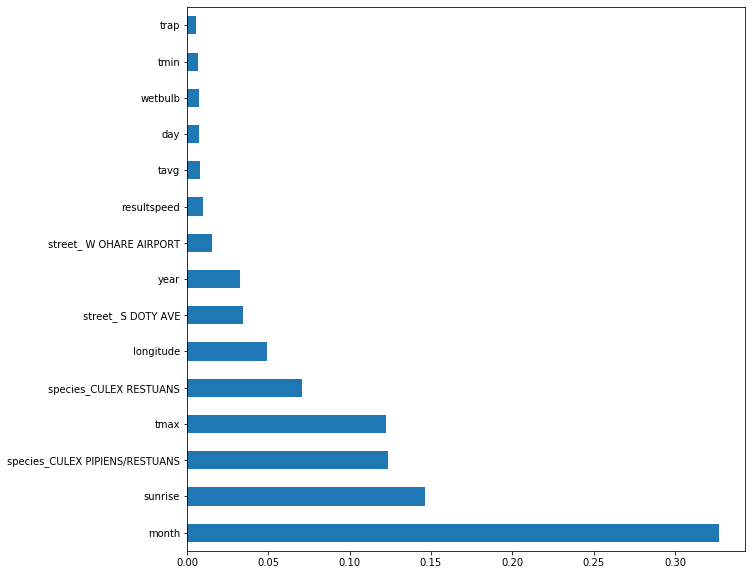

In [123]:
# Generate top 15 Important Features 
importance = dtree.feature_importances_
feat_importances = pd.Series(dtree.feature_importances_, index=main_df_test_D2.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(10,10))

In [124]:
# Kaggle Score 0.61955, Private Score 0.62076
submission = pd.DataFrame(dtree.predict_proba(main_df_test_D2)[:,1], columns = ['WnvPresent'])
submission.set_index(np.arange(1, main_df_test_D2.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.WnvPresent = submission.WnvPresent.round(0).astype(int)
submission.to_csv('../datasets/submission_d1.csv', index = False)

#### Modeling - K Nearest Neighbhor

In [125]:
#Set up pipeline with K-Nearest Neighbhor
pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())
])
# Search over the following values of hyperparameters:
pipe_params_knn = {
    'knn__n_neighbors': [2, 3, 5]
}
# Instantiate GridSearchCV
grid_knn = GridSearchCV(pipe_knn, param_grid=pipe_params_knn, cv=10, scoring='accuracy', n_jobs=-1)
# Fit GridSearch to training data.
grid_knn.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'knn__n_neighbors': [2, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [126]:
# Best Score, Parameter and Model Using GridSearch
print(f"Best Score: {round(grid_knn.best_score_, 4)}")
print(f"Best Model: {round(grid_knn.best_estimator_.score(X_test, y_test,),4)}")
print(f"Best Parameter: {grid_knn.best_params_}")

Best Score: 0.8932
Best Model: 0.9068
Best Parameter: {'knn__n_neighbors': 2}


In [127]:
# Fit our model
# Generate our predictions!
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_sm, y_train_sm)
print(f"Train Score: {round(knn.score(X_train_sm, y_train_sm), 4)}")
print(f"Test Score: {round(knn.score(X_test, y_test), 4)}")

Train Score: 0.9475
Test Score: 0.9068


In [128]:
# Generate the classification report
y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1992
           1       0.16      0.18      0.17       110

    accuracy                           0.91      2102
   macro avg       0.56      0.56      0.56      2102
weighted avg       0.91      0.91      0.91      2102



In [129]:
# Generate a confusion matrix
# Assign to TN,FP,FN and TP
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1886
False Positives: 106
False Negatives: 90
True Positives: 20


In [130]:
Accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Model Accuracy: {(Accuracy)}")
Sensitivity = tp / (tp + fn)
print(f"Model Sensitivity: {Sensitivity}")
Specificity = tn / (tn + fp)
print(f"Model Specificity: {Specificity}")
Precision = tp / (tp + fp)
print(f"Model Precision: {Precision}")

Model Accuracy: 0.9067554709800191
Model Sensitivity: 0.18181818181818182
Model Specificity: 0.9467871485943775
Model Precision: 0.15873015873015872


In [131]:
X_train_sm.shape

(11936, 157)

In [132]:
main_df_test_D2.shape

(116293, 157)

In [133]:
# Kaggle Score 0.59756 and Private Score 0.58256
sub = pd.DataFrame(knn.predict_proba(main_df_test_D2)[:,1], columns = ['WnvPresent'])
sub.set_index(np.arange(1, main_df_test_D2.shape[0] + 1), inplace=True)
sub = sub.reset_index().rename(columns = {'index':'Id'})
sub.WnvPresent = sub.WnvPresent.round(0).astype(int)
sub.to_csv('../datasets/submission_d2.csv', index = False)

#### Modeling - Random Forest Classifier

In [134]:
#Set up pipeline with Random Forest
pipe_rfc = Pipeline([
    ('rfc', RandomForestClassifier())
])
# Search over the following values of hyperparameters:
params_rfc = {
    'rfc__n_estimators': [100],
    'rfc__max_depth': [5, 7],
    'rfc__min_samples_split': [12, 14],
    'rfc__min_samples_leaf': [3, 4],
}
# Instantiate GridSearchCV
grid_rfc = GridSearchCV(pipe_rfc, param_grid=params_rfc, cv=10, verbose=1)
# Fit GridSearch to training data.
grid_rfc.fit(X_train_sm, y_train_sm)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                             

In [135]:
# Best Score, Parameter and Model Using GridSearch
print(f"Best Score: {round(grid_rfc.best_score_, 4)}")
print(f"Best Model: {round(grid_rfc.best_estimator_.score(X_test, y_test,),4)}")
print(f"Best Parameter: {grid_rfc.best_params_}")

Best Score: 0.8969
Best Model: 0.9125
Best Parameter: {'rfc__max_depth': 7, 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 12, 'rfc__n_estimators': 100}


In [136]:
# Fit our model
# Generate our predictions!
rfc = RandomForestClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=14, n_estimators=100)
rfc.fit(X_train_sm, y_train_sm)
print(f"Train Score: {round(rfc.score(X_train_sm, y_train_sm), 4)}")
print(f"Test Score: {round(rfc.score(X_test, y_test), 4)}")

Train Score: 0.9071
Test Score: 0.9115


In [137]:
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1992
           1       0.25      0.34      0.28       110

    accuracy                           0.91      2102
   macro avg       0.60      0.64      0.62      2102
weighted avg       0.93      0.91      0.92      2102



In [138]:
# Generate a confusion matrix
# Assign to TN,FP,FN and TP
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1879
False Positives: 113
False Negatives: 73
True Positives: 37


In [139]:
Accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Model Accuracy: {(Accuracy)}")
Sensitivity = tp / (tp + fn)
print(f"Model Sensitivity: {Sensitivity}")
Specificity = tn / (tn + fp)
print(f"Model Specificity: {Specificity}")
Precision = tp / (tp + fp)
print(f"Model Precision: {Precision}")

Model Accuracy: 0.9115128449096099
Model Sensitivity: 0.33636363636363636
Model Specificity: 0.9432730923694779
Model Precision: 0.24666666666666667


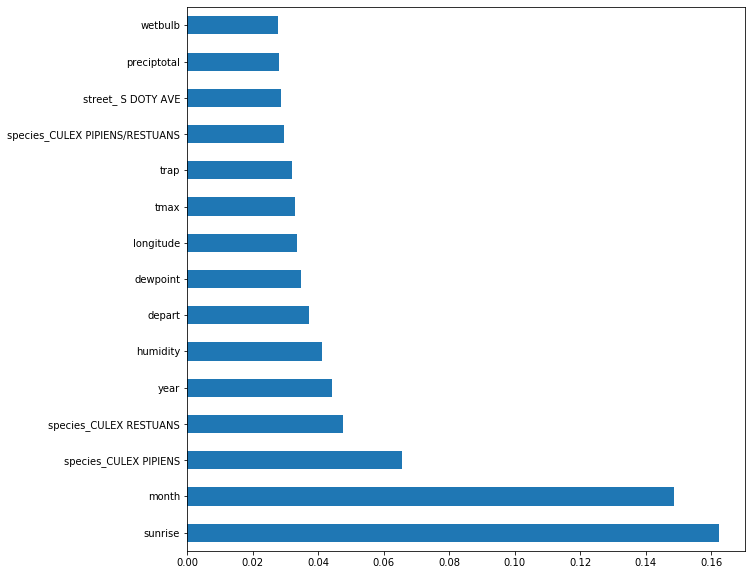

In [140]:
# Identify the top 15 features
importance = rfc.feature_importances_
feat_importances = pd.Series(rfc.feature_importances_, index=main_df_test_D2.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(10,10))

In [141]:
# Kaggle score 0.50, Private Score 0.50
submission = pd.DataFrame(rfc.predict_proba(main_df_test_D2)[:,1], columns = ['WnvPresent'])
submission.set_index(np.arange(1, main_df_test_D2.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.WnvPresent = submission.WnvPresent.round(0).astype(int)
submission.to_csv('../datasets/submission_d3.csv', index = False)

---

## Conclusion and Recommendations

|Approach|Private Kaggle Score| Public Kaggle Score|
|---|---|---|
|Approach A|0.57147|0.61725|
|Approach B|0.57810|0.60837|
|Approach C|0.65931|0.65337|
|Approach D|0.62076|0.61955| 

Based on the summary of the Kaggle results, Approach C performs the best overall in predicting the presence of West Nile Virus.
It selected the Voting Classifier, consisting of a few models: K-Nearest Neighbours, AdaBoosted Decision Trees, Bagging Classifier, Random Forest Classifier and Gradient Boosting Classifier, to perform the prediction and has an excellent ROC AUC score of 0.955 on train data. Therefore, our team has selected this model to be the prediction model for our problem statement.

From this model, we were able to extract the more important features that predict the presence of West Nile Virus. They are, in order of importance: 

    1) Location (trap, block)
    2) time (sunset, month)
    3) weather (cool, avgspeed, tavg).

**Recommendations**

For our modeling, we found a few disparity between the train and test datasets. The train dataset has only 10506 entries, compared to the test dataset which has 116293 entries. It will be better for our modeling if we can acquire more data for the training dataset.

Based on our EDA, `nummosquito` information appears to be helpful for our prediction. However, we are unable to use it as the test dataset did not have the `nummosquito` information. 

Finally, none of the traps in the test dataset is affected by spraying activity. This makes it difficult to ascertain the impact of spraying on predicting West Nile Virus.

In addition, we see that the location is a strong predictor. Additional geospatial information like human density or city zoning information may help us understand better why certain WNV carrying mosquitos species tend to breed at certain parts of the city and what might be contributing to the favorable environment.

Lastly, further study can be conducted on the methodology of spraying. Based on our EDA, the impact of spraying on mosquito population in the locality is inconclusive. Addressing the cost-benefits of spraying,  we do not recommend changing the spraying routines until the effectiveness of spraying can be confirmed. Instead, conducting additional inspections at high risk sites and carrying out preventive measures such as clearing stagnant water or application of mosquito oil might be more effective.

Further studies on the frequency of spraying or how city workers perform the spraying, i.e. walking a circle around a block or a team approaching the block from multiple directions, can help improve the effectiveness of spraying and curb mosquito population, and by extension, West Nile Virus transmission during the summer months. 

## Annex A - Data Dictionary for main_df

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**station**|*int*|main_df|Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT (AWOS)|
|**date**|*datetime*|main_df|Date Period of Weather Data (YYYY-MM-DD)|
|**tmax**|*float*|main_df|Maximum Daily Temperature (Degrees Celsius)|
|**tmin**|*float*|main_df|Minimum Daily Temperature (Degrees Celsius)|
|**tavg**|*float*|main_df|Average Daily Temperature (Degrees Celsius)|
|**depart**|*float*|main_df|Daily Departure From Normal (Degrees Celsius)|
|**dewpoint**|*float*|main_df|Average Daily Dew Point (Degrees Celsius)|
|**wetbulb**|*float*|main_df|Average Daily Wetbulb (Degrees Celsius)|
|**humidity**|*float*|main_df|Average Daily Humidity (Degrees Celsius)|
|**heat**|*float*|main_df|Daily Heating (Season Begins In July)|
|**cool**|*float*|main_df|Daily Cooling (Season Begins In January)|
|**sunrise**|*float*|main_df|Daily Sunrise Time (HHMM)|
|**sunset**|*float*|main_df|Daily Sunset Time (HHMM)|
|**codesum**|*object*|main_df|Significant Weather Types/Phenomena|
|**depth**|*int*|main_df|Measurement of Snow/Ice On Ground(Inches)|
|**snowfall**|*float*|main_df|Measurement of Snowfall (Inches and Tenths)|
|**preciptotal**|*float*|main_df|Daily Precipitation (Inches)|
|**stnpressure**|*float*|main_df|Average Daily Station Pressure (Inches HG)|
|**sealevel**|*float*|main_df|Average Daily Sea Level Pressure (Inches HG)|
|**resultspeed**|*float*|main_df|Daily Resultant Wind Speed (MPH)|
|**resultdir**|*int*|main_df|Daily Resultant Direction (Whole Degrees)|
|**avgspeed**|*float*|main_df|Average Daily Resultant Wind Speed (MPH)|
|**day**|*int*|main_df|Date Period of Weather Data (Day)|
|**month**|*int*|main_df|Date Period of Weather Data (Month)|
|**year**|*int*|main_df|Date Period of Weather Data (Year)|
|**address**|*object*|main_df|Full Address of the Trap (Location)|
|**species**|*object*|main_df|Species of Mosquitos in the Trap (7 Types)|
|**block**|*int*|main_df|Block of the Neighbhorhood (Location)|
|**street**|*object*|main_df|Street of the Trap (Location)|
|**trap**|*int*|main_df|Apparatus Designed to Catch Mosquitos (Location)|
|**addressnumberandstreet**|*object*|main_df|Full Address of the Trap (Location)|
|**latitude**|*float*|main_df|Geographic Coordinate that Specifies North or South Position (Location)|
|**longitude**|*float*|main_df|Geographic Coordinate that Specifies East or West Position (Location)|
|**addressaccuracy**|*int*|main_df|Accuracy of Address to Logitude and Latitude (Location)|
|**nummosquitos**|*int*|main_df|Number of Mosquitos Caught in the Trap|
|**wnvpresent**|*int*|Weather|One or More Mosquitos in the Trap has West Nile Virus|
|**iswnvspecies**|*int*|Weather|Type of Mosquitos tha Carry West Nile Virus|
|**is_spray**|*bool*|Weather| Location that has been Sprayed|